# Universe Machine mass functions

* SMF of the new UM when considering in-situ, ex-situ, and the sum of both compared to Songs SMF
* look at the scatter in M* and Mhalo
- for in-situ
- for in-situ + ex-situ
- for N most massive galaxies

TODO:
* Once things are restructured get this ready for PR
* Cleanup figures
    * Consistent labels
    * Large labels everywhere
    * consider adding contours? Might be interesting
    * No titles
* SMF with new data (get from songs repo)
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
* We lose the inversions when only starting at m halo = 13
* Decide how to drop data in the heatmaps
* check for h factors
* https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

# Preamble, Imports, Plotting config

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [10]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.io.fits
import time

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# Local libs
import sys
sys.path.append("..")

import plots, heatmaps, smhm_fit, cluster_sum, data
import lib.stellar_mass_function as smf

In [41]:
matplotlib.rcParams.update({'figure.dpi': 600})
def fig_font_size(size = 12):
    matplotlib.rcParams.update({'font.size': size})
fig_font_size()

# Data

In [72]:
centrals, satellites = data.load()

In [73]:
centrals_insitu_cut, centrals_stellar_cut, centrals_halo_cut = data.cut_centrals(centrals)
data_stellar_cut = data.get_with_sats(centrals_stellar_cut, satellites, smhm_fit.get_fit)
data_halo_cut = data.get_with_sats(centrals_halo_cut, satellites, smhm_fit.get_fit_2)

In [75]:
centrals_insitu_cut["icl"] = 0
data_stellar_cut["insitu"] = {
    "data": centrals_insitu_cut,
    "fit": smhm_fit.get_fit(centrals_insitu_cut),
}
insitu = np.copy(data_halo_cut["cen"]["data"])
insitu["icl"] = 0
data_halo_cut["insitu"] = {
    "data": insitu,
    "fit": smhm_fit.get_fit_2(insitu),
}

In [76]:
data_halo_cut.keys()

dict_keys(['cen', 1, 2, 5, 'halo', 'insitu'])

# Intro Plot

Intro everything by showing the SM-HM plot + some of the sigma plots

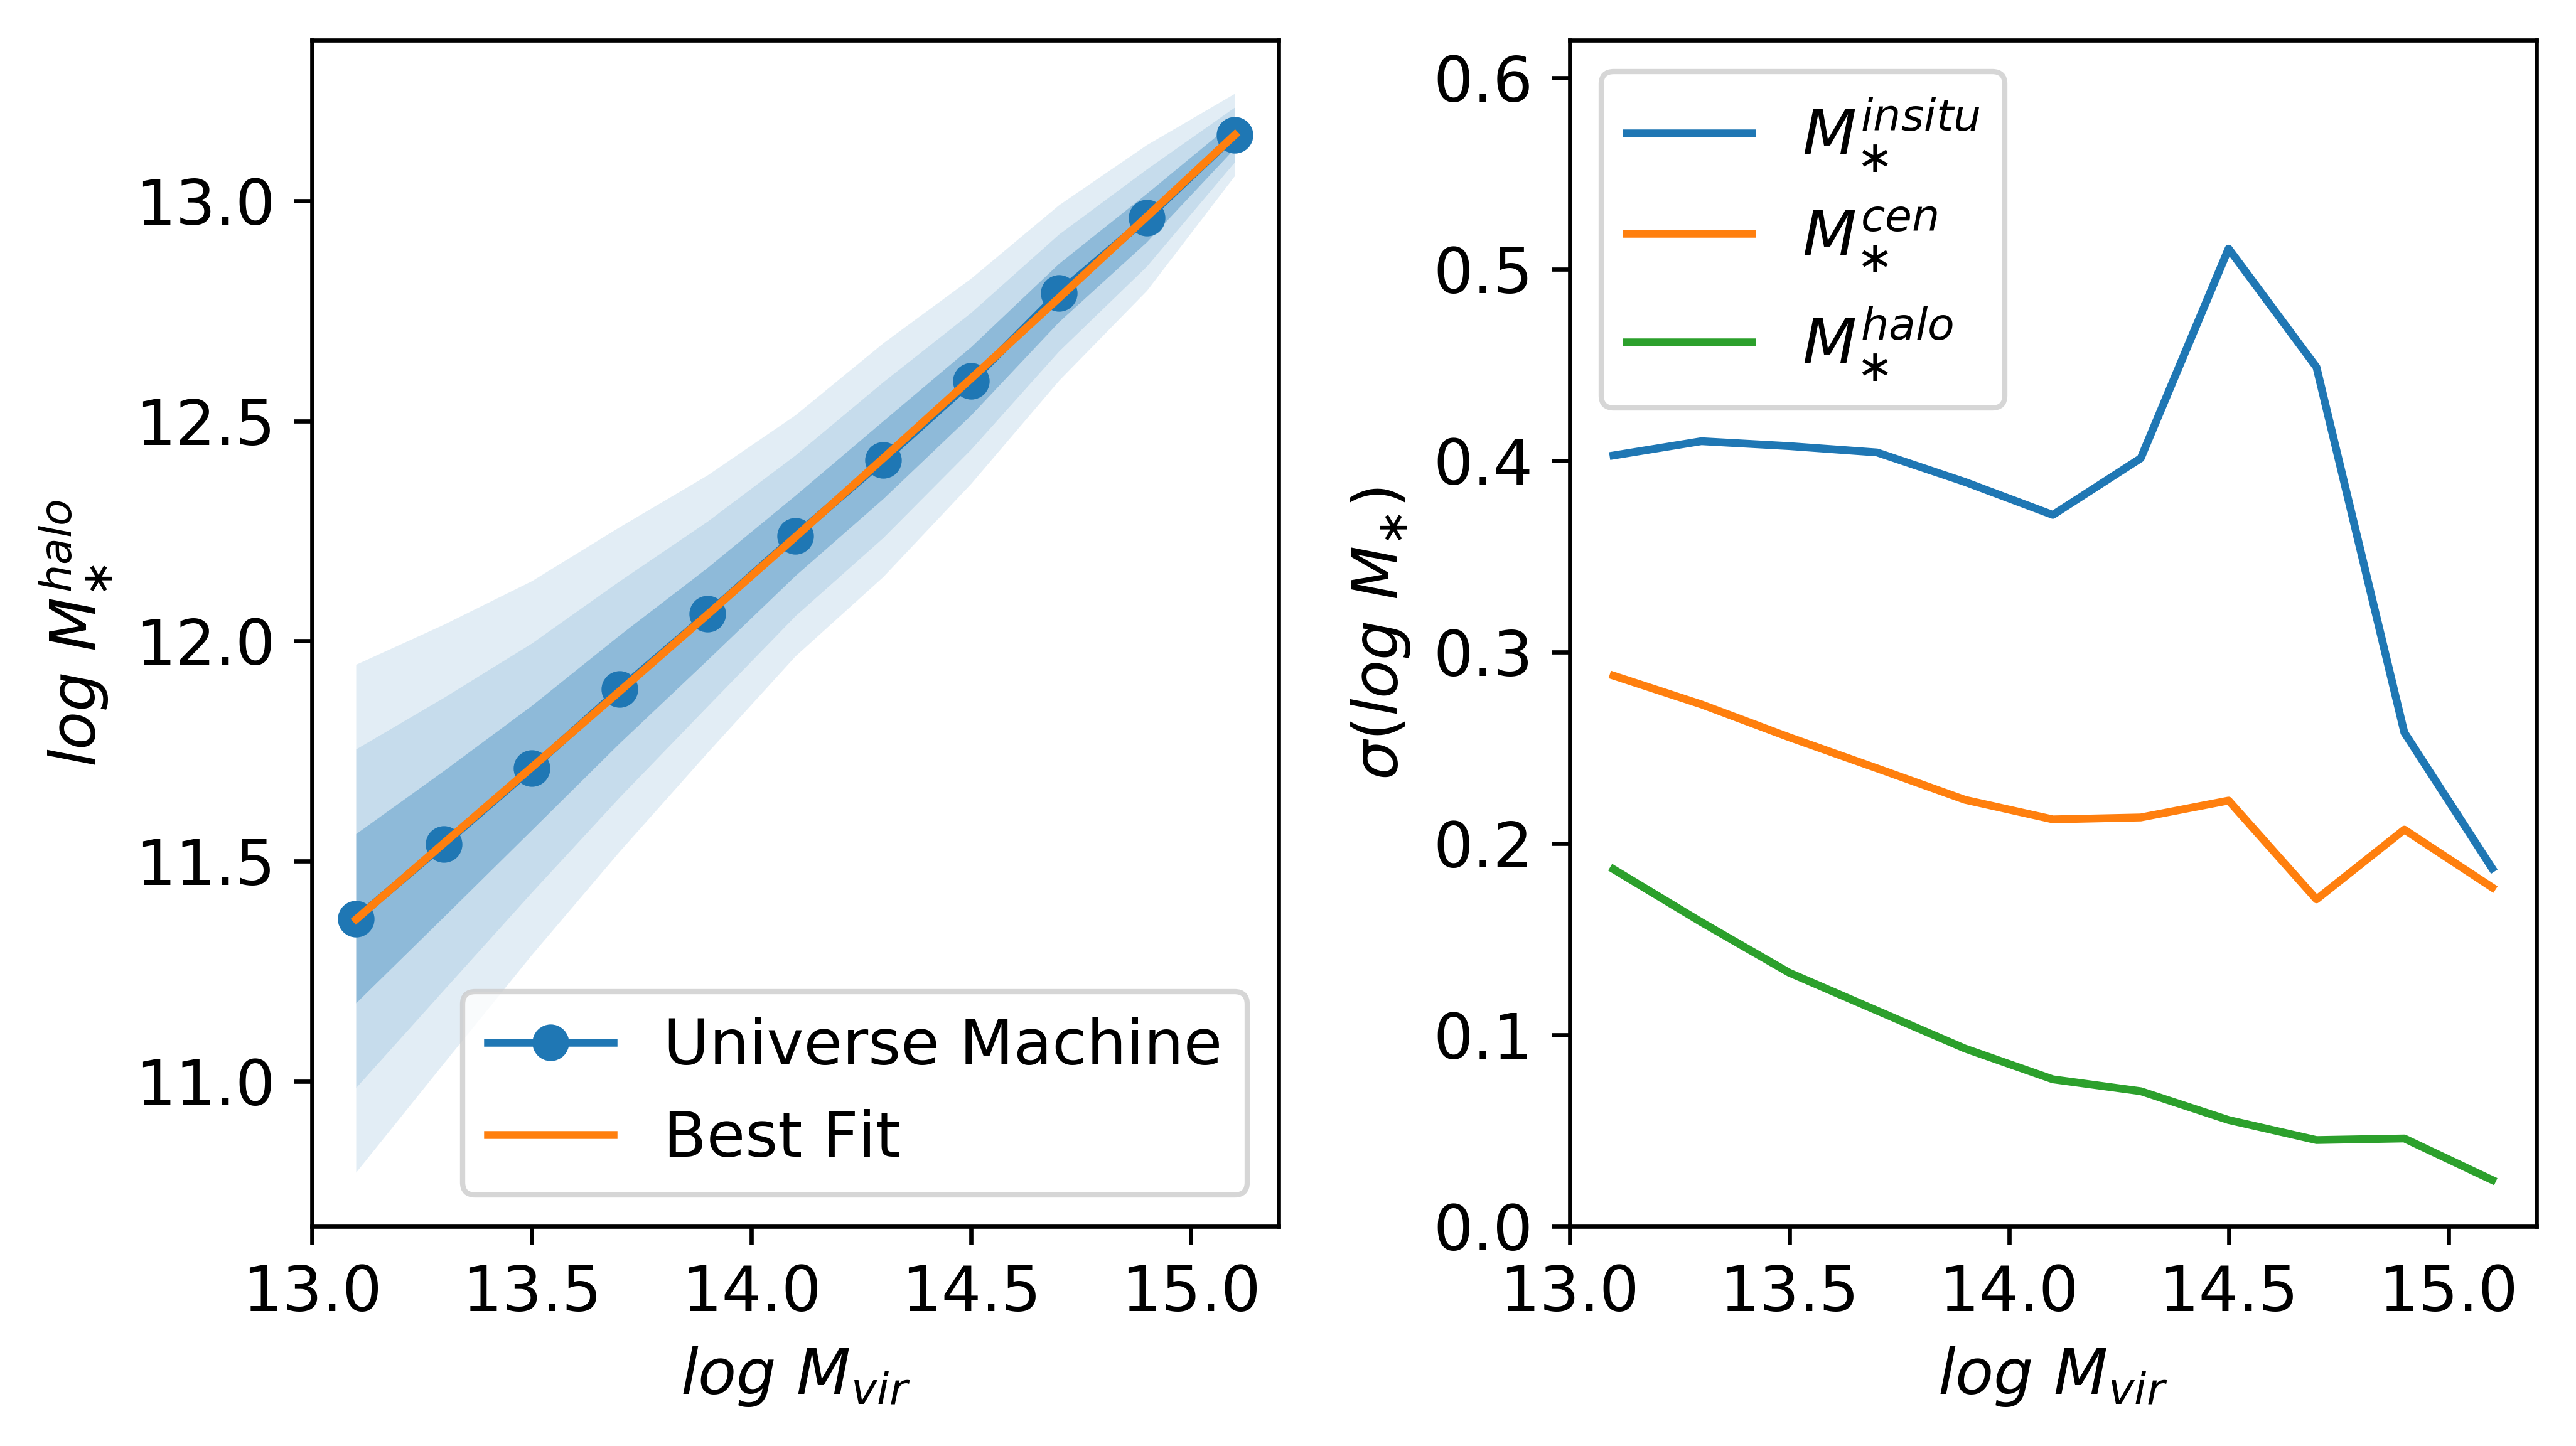

In [89]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
plots.sm_vs_dm(data_halo_cut["halo"]["data"], "halo", fit=data_halo_cut["halo"]["fit"], ax=axes[0])
plots.hm_vs_sm_scatter_variant(data_halo_cut, ax=axes[1])
plt.tight_layout()

# SMHM ratio scatter for clusters

What happens if we start to plot this relation for multiple members of the cluster?

(0.023964796771833698, 0.46488217293909834)

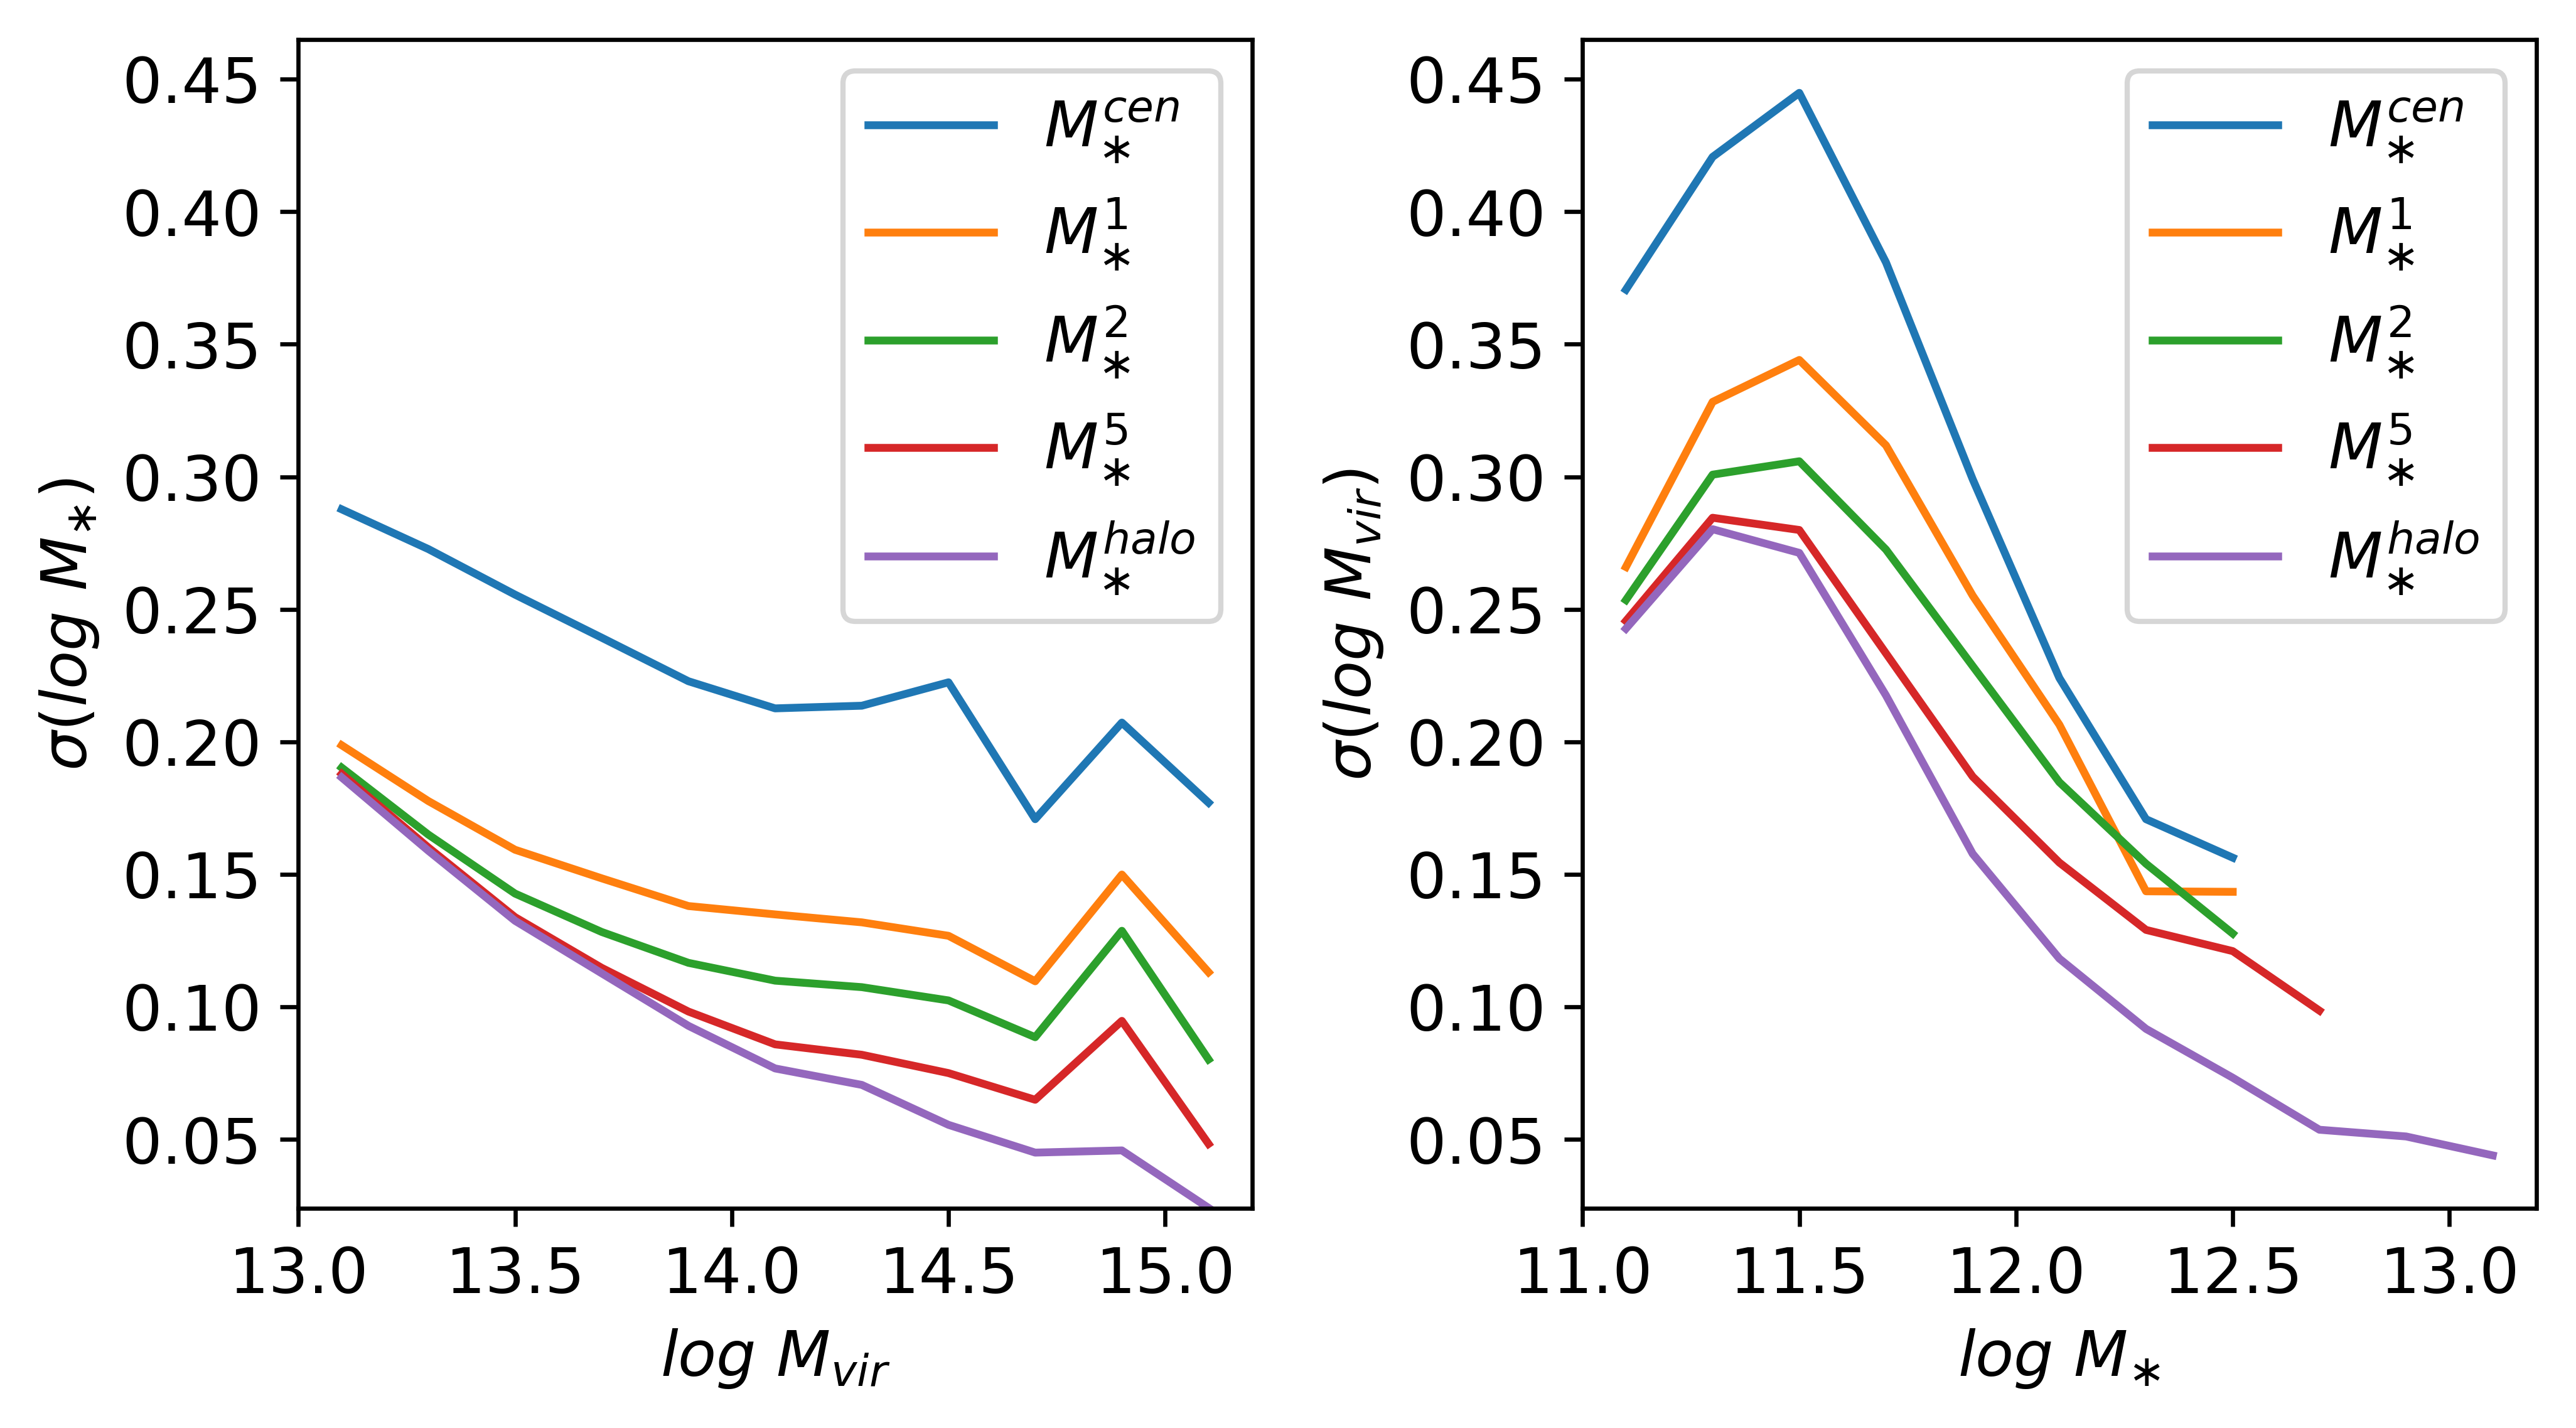

In [88]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
plots.hm_vs_sm_scatter(data_halo_cut, ax=axes[0])
plots.sm_vs_hm_scatter(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# SMF

What does our SMF look like? 

In [202]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [203]:
print(m10_smf.dtype)
print(m10_smf)

(numpy.record, [('logm_mean', '>f8'), ('logm_0', '>f8'), ('logm_1', '>f8'), ('smf', '>f8'), ('smf_err', '>f8'), ('smf_low', '>f8'), ('smf_upp', '>f8')])
[ ( 10.45,  10.4,  10.5,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.55,  10.5,  10.6,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.65,  10.6,  10.7,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.75,  10.7,  10.8,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00,   0.00000000e+00)
 ( 10.85,  10.8,  10.9,   1.23958176e-07,   2.48352780e-08,  -2.47916352e-08,   2.72707987e-07)
 ( 10.95,  10.9,  11. ,   2.47916352e-07,   4.96449906e-08,   7.43749056e-08,   4.21457798e-07)
 ( 11.05,  11. ,  11.1,   4.95832704e-07,   9.92538264e-08,   1.48749811e-07,   8.42915597e-07)
 ( 11.15,  11.1,  11.2,   6.44582515e-06,   1.28947974e-06,   4.28895289e-06,   8.60269741e-06)
 ( 11.25,  11.2,  11.3,   3.94187000e-05,   7.88451825e-06,   2.95516291e-05, 

Dropped 0 galaxies with mass of 0
Dropped 0 galaxies with mass of 0
Dropped 4 galaxies with mass of 0


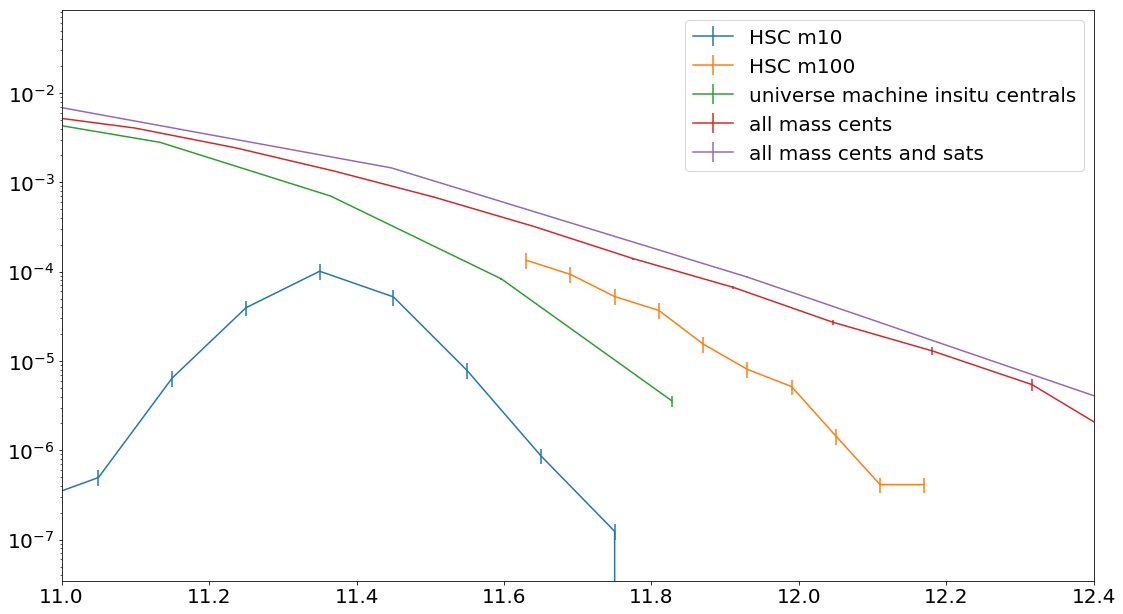

In [210]:
reload(smf)

def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness

What about richness? Does that have a relation with scatter at fixed halo mass

Out of 36491 clusters, 22803 have a richness > 0


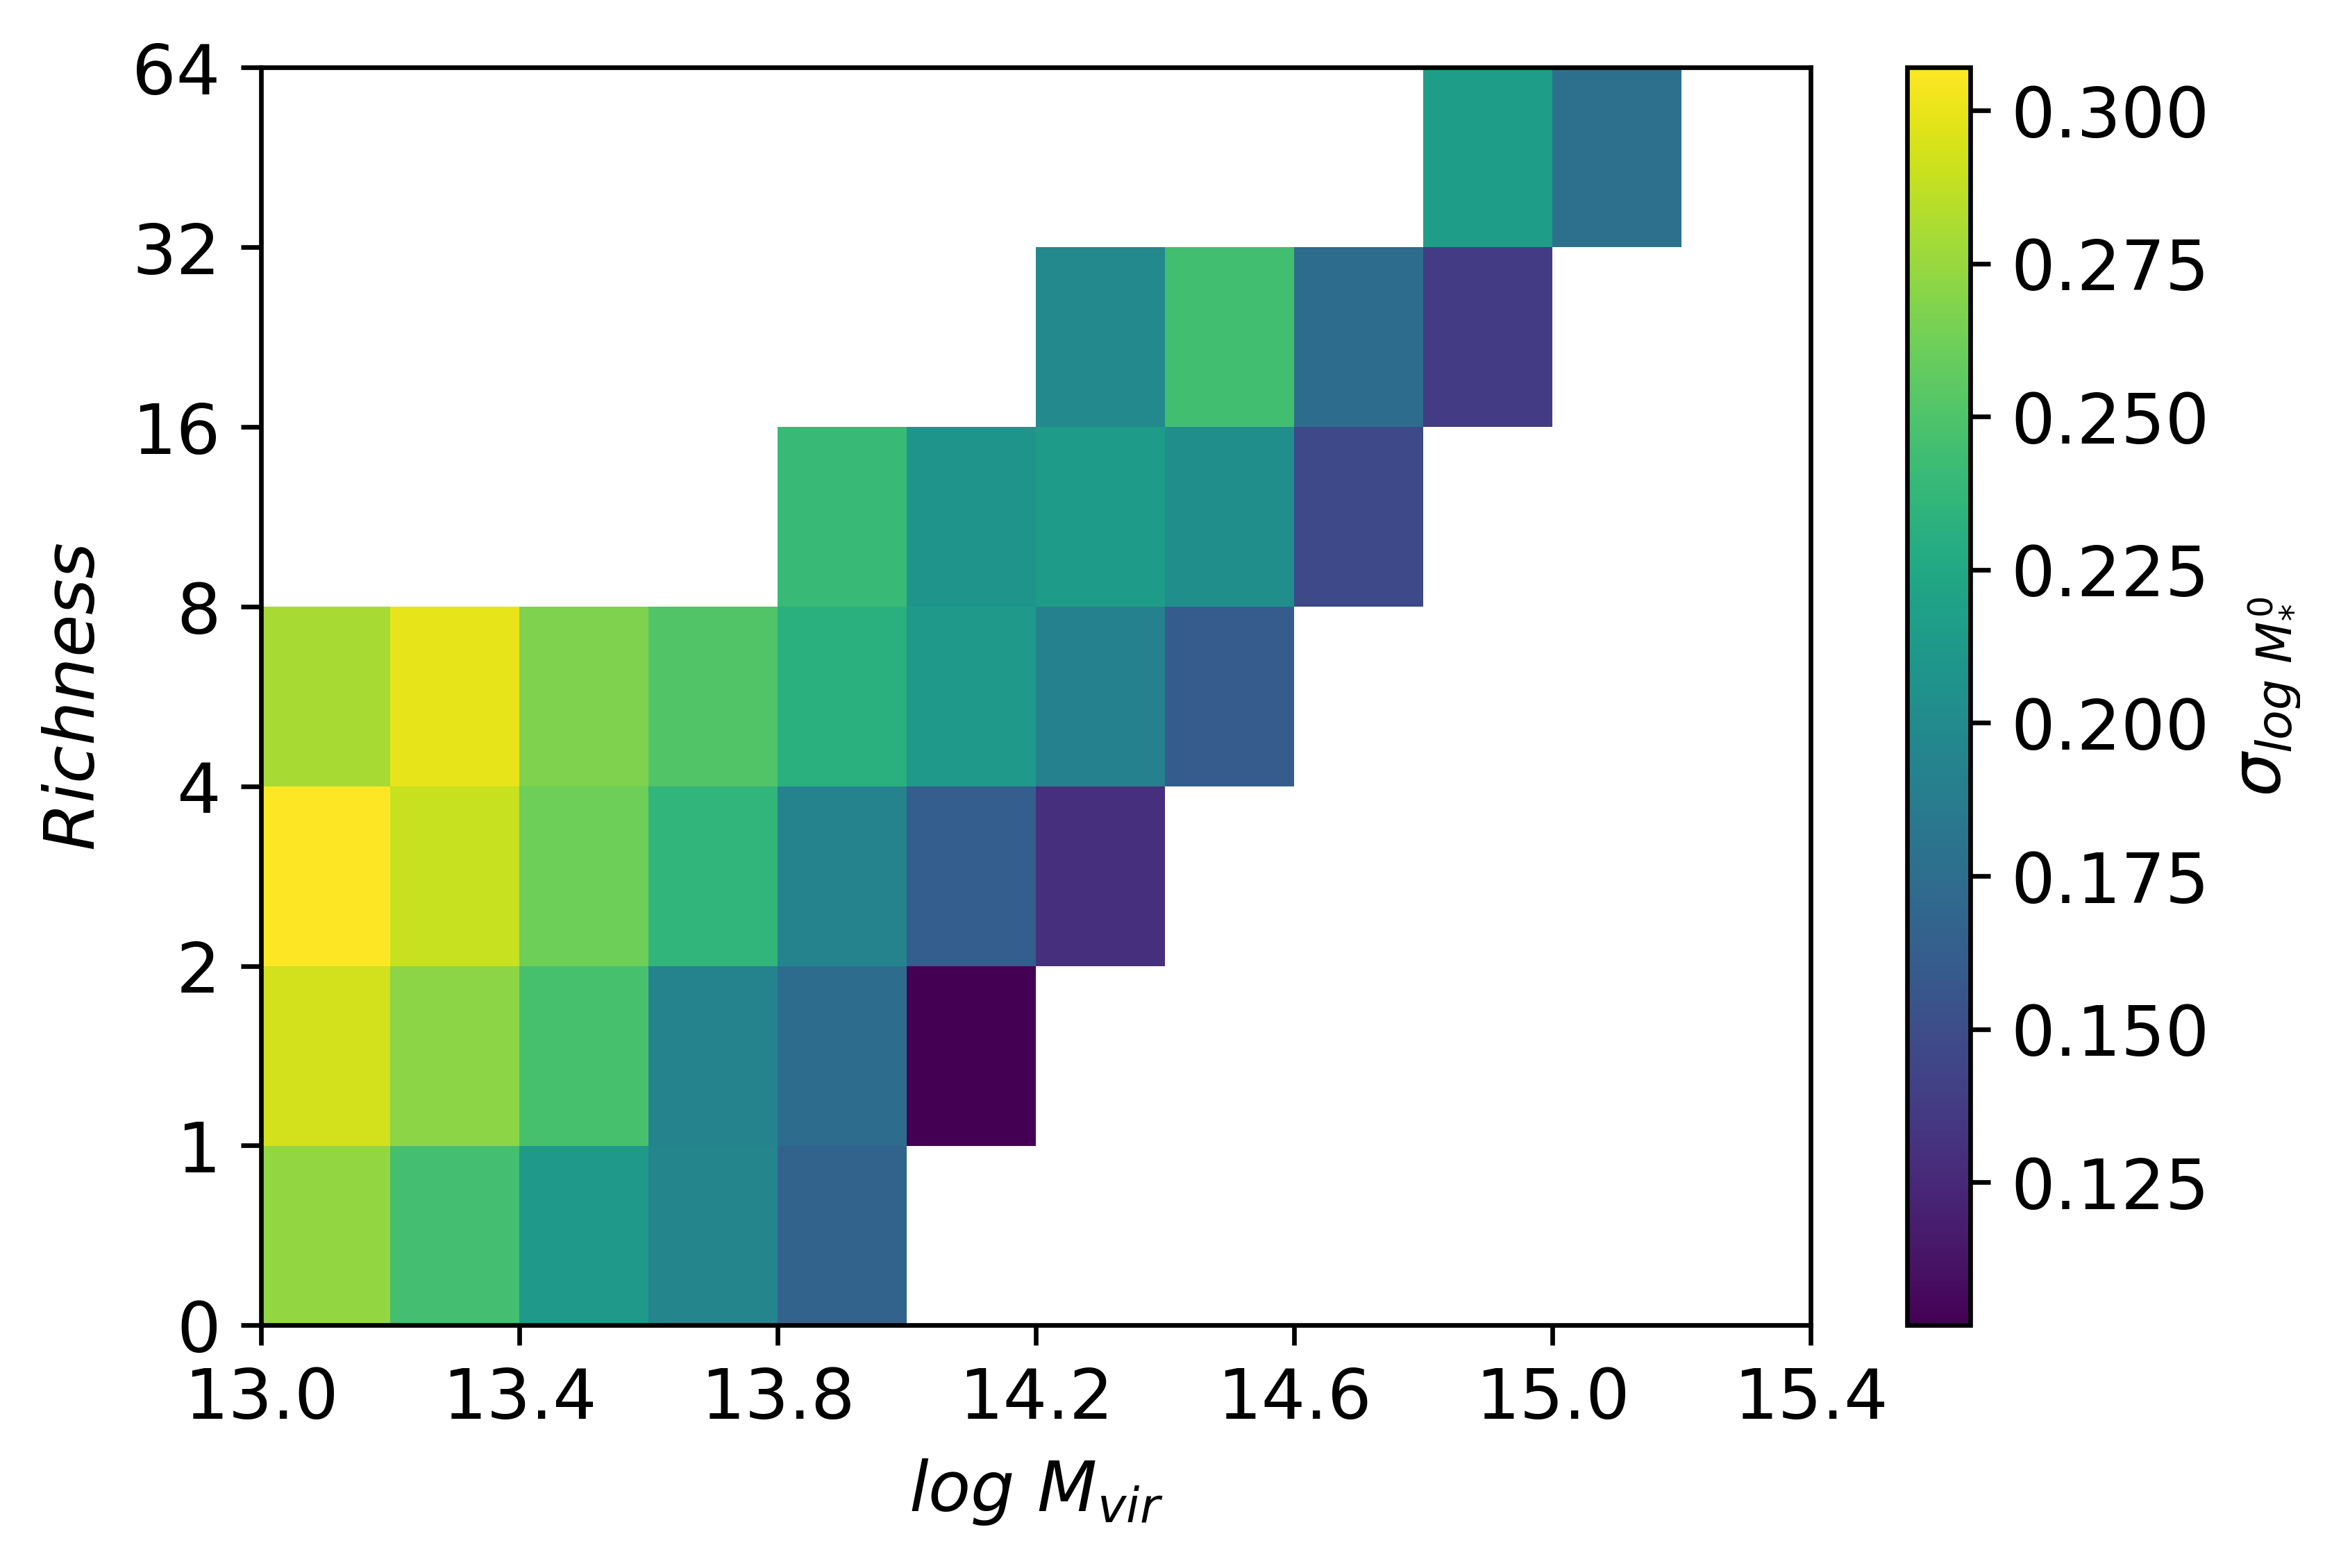

In [108]:
# Only count sats of a large enough size towards richness
minMassForRichness = 10**10.8
richness = cluster_sum.get_richness(centrals_halo_cut, satellites, minMassForRichness)
print("Out of {} clusters, {} have a richness > 0".format(len(richness), np.count_nonzero(richness)))
heatmaps.richness_and_hm_vs_sm_scatter(
    data_halo_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_halo_cut[0]["fit"],
    0,
)

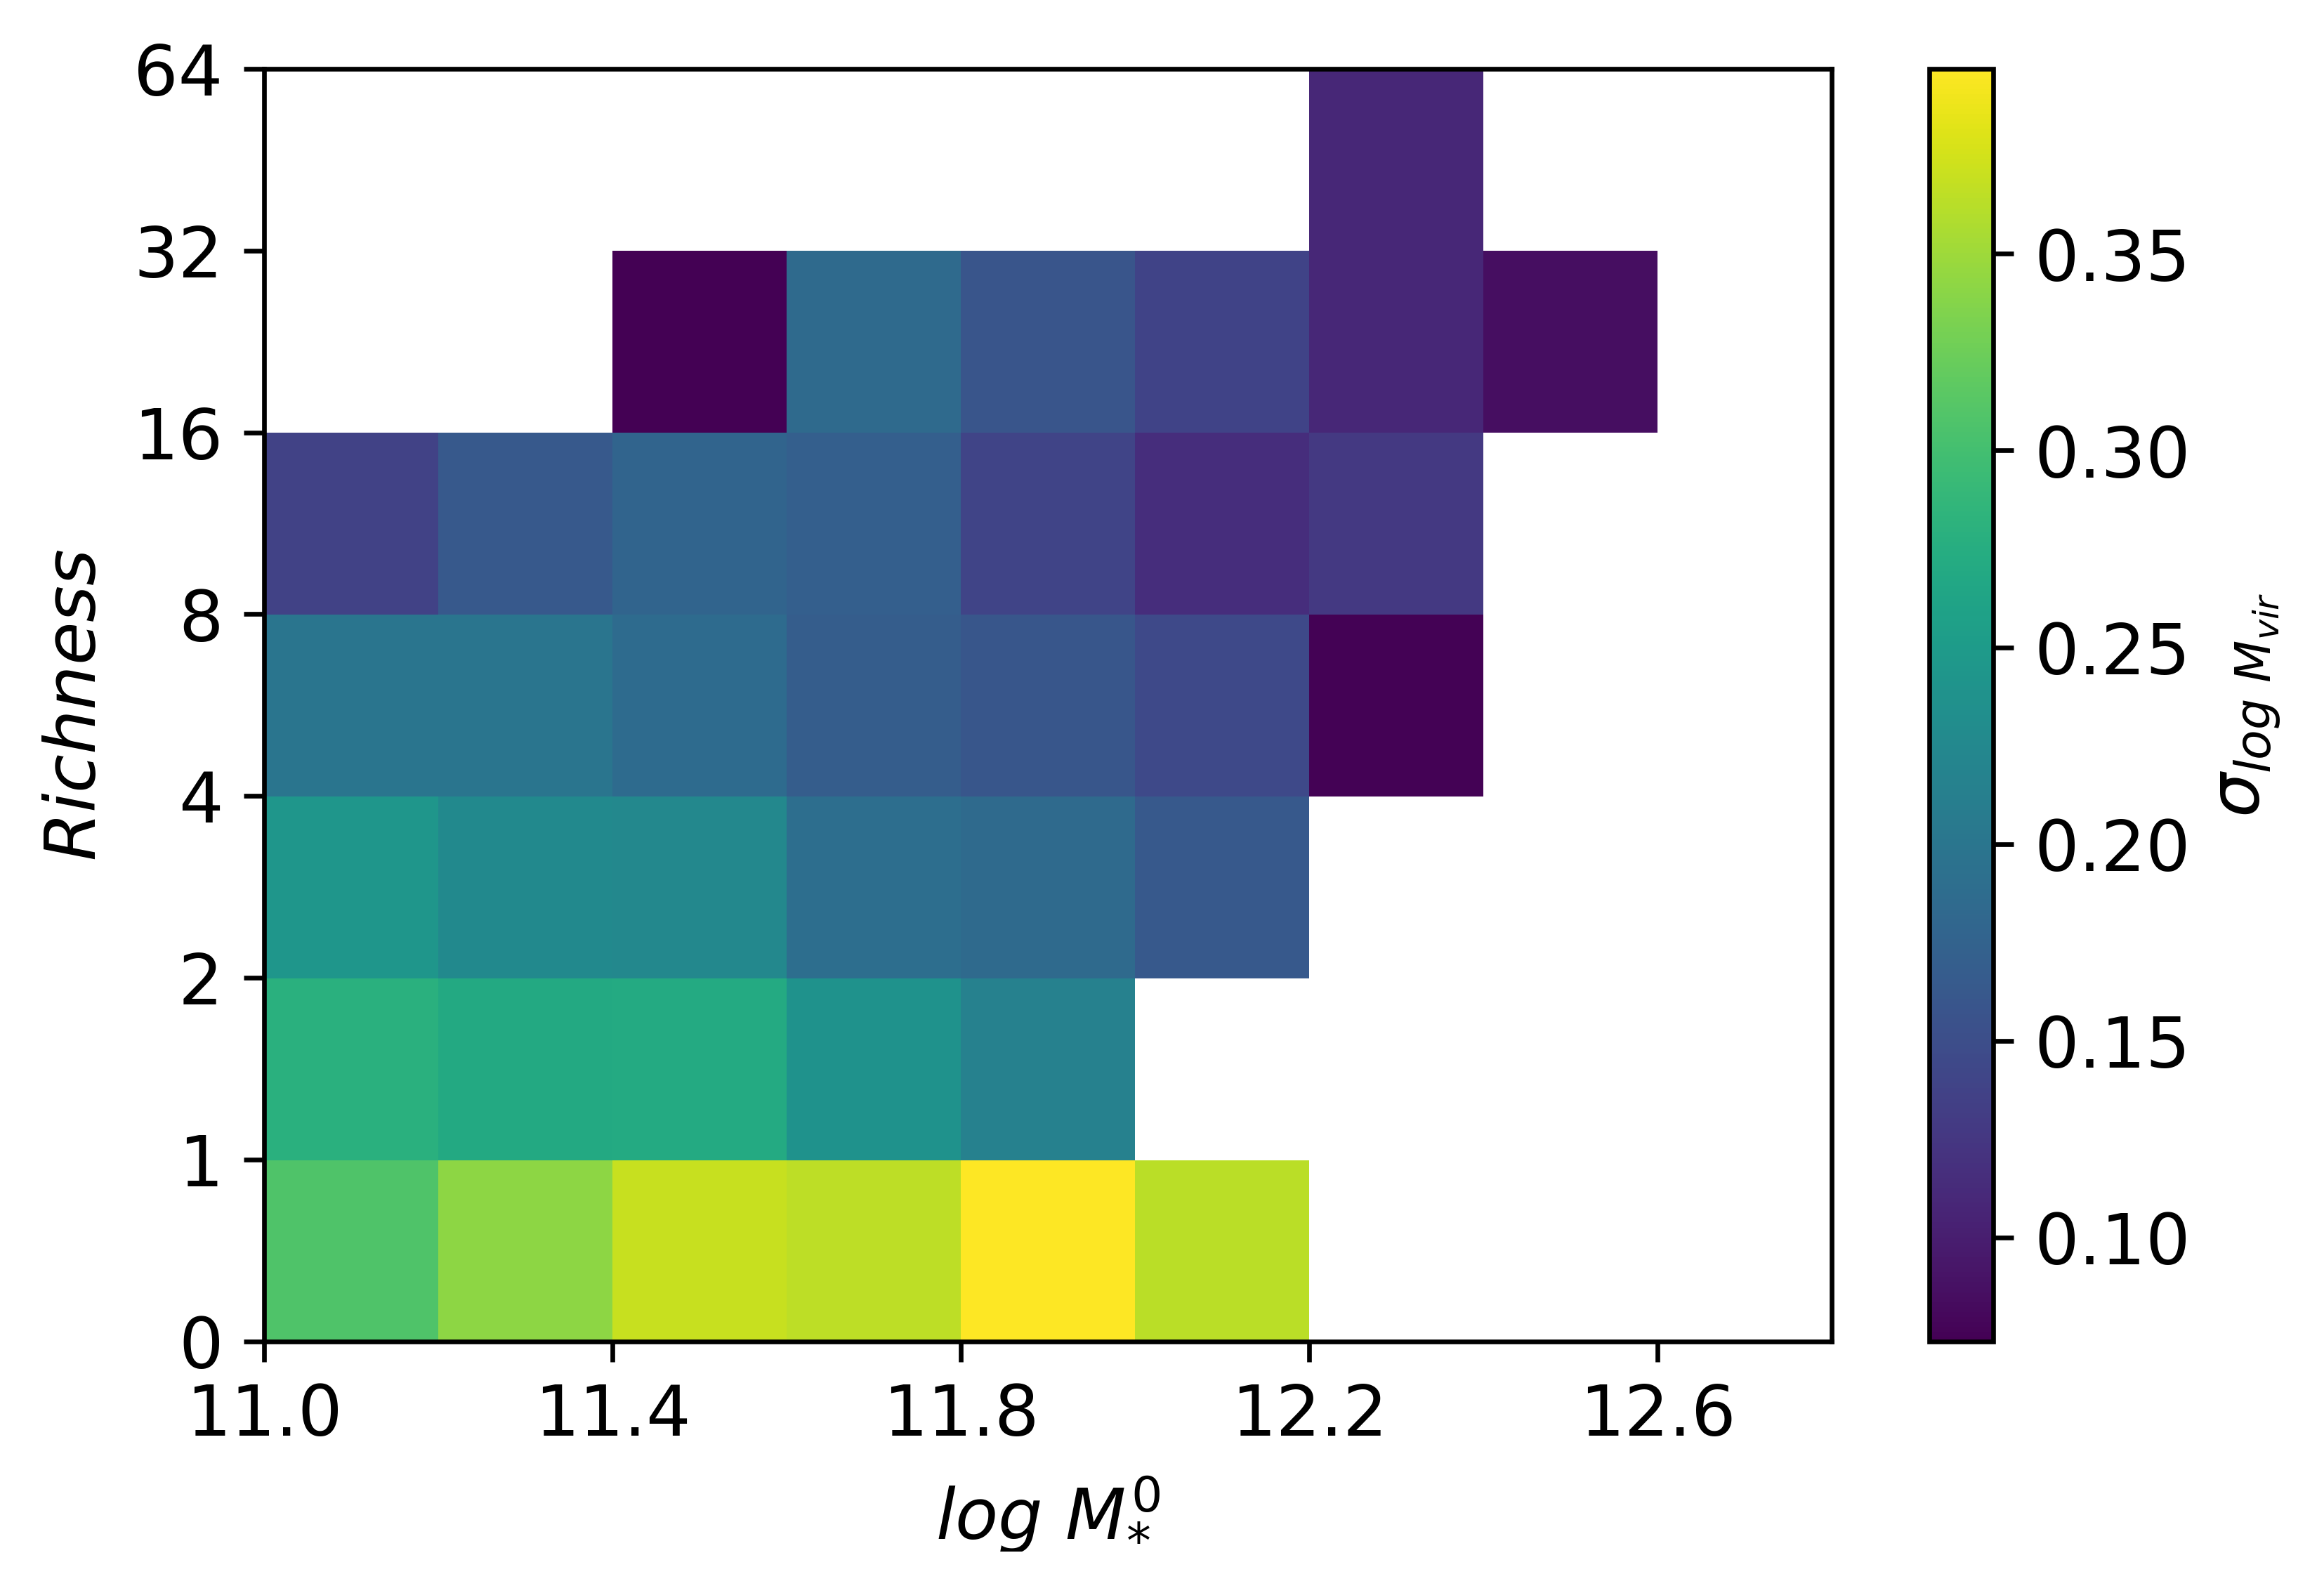

In [109]:
heatmaps.richness_and_sm_vs_hm_scatter(
    data_stellar_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_stellar_cut[0]["fit"],
    0,
)

# Concentration

Same as richness but for concentration

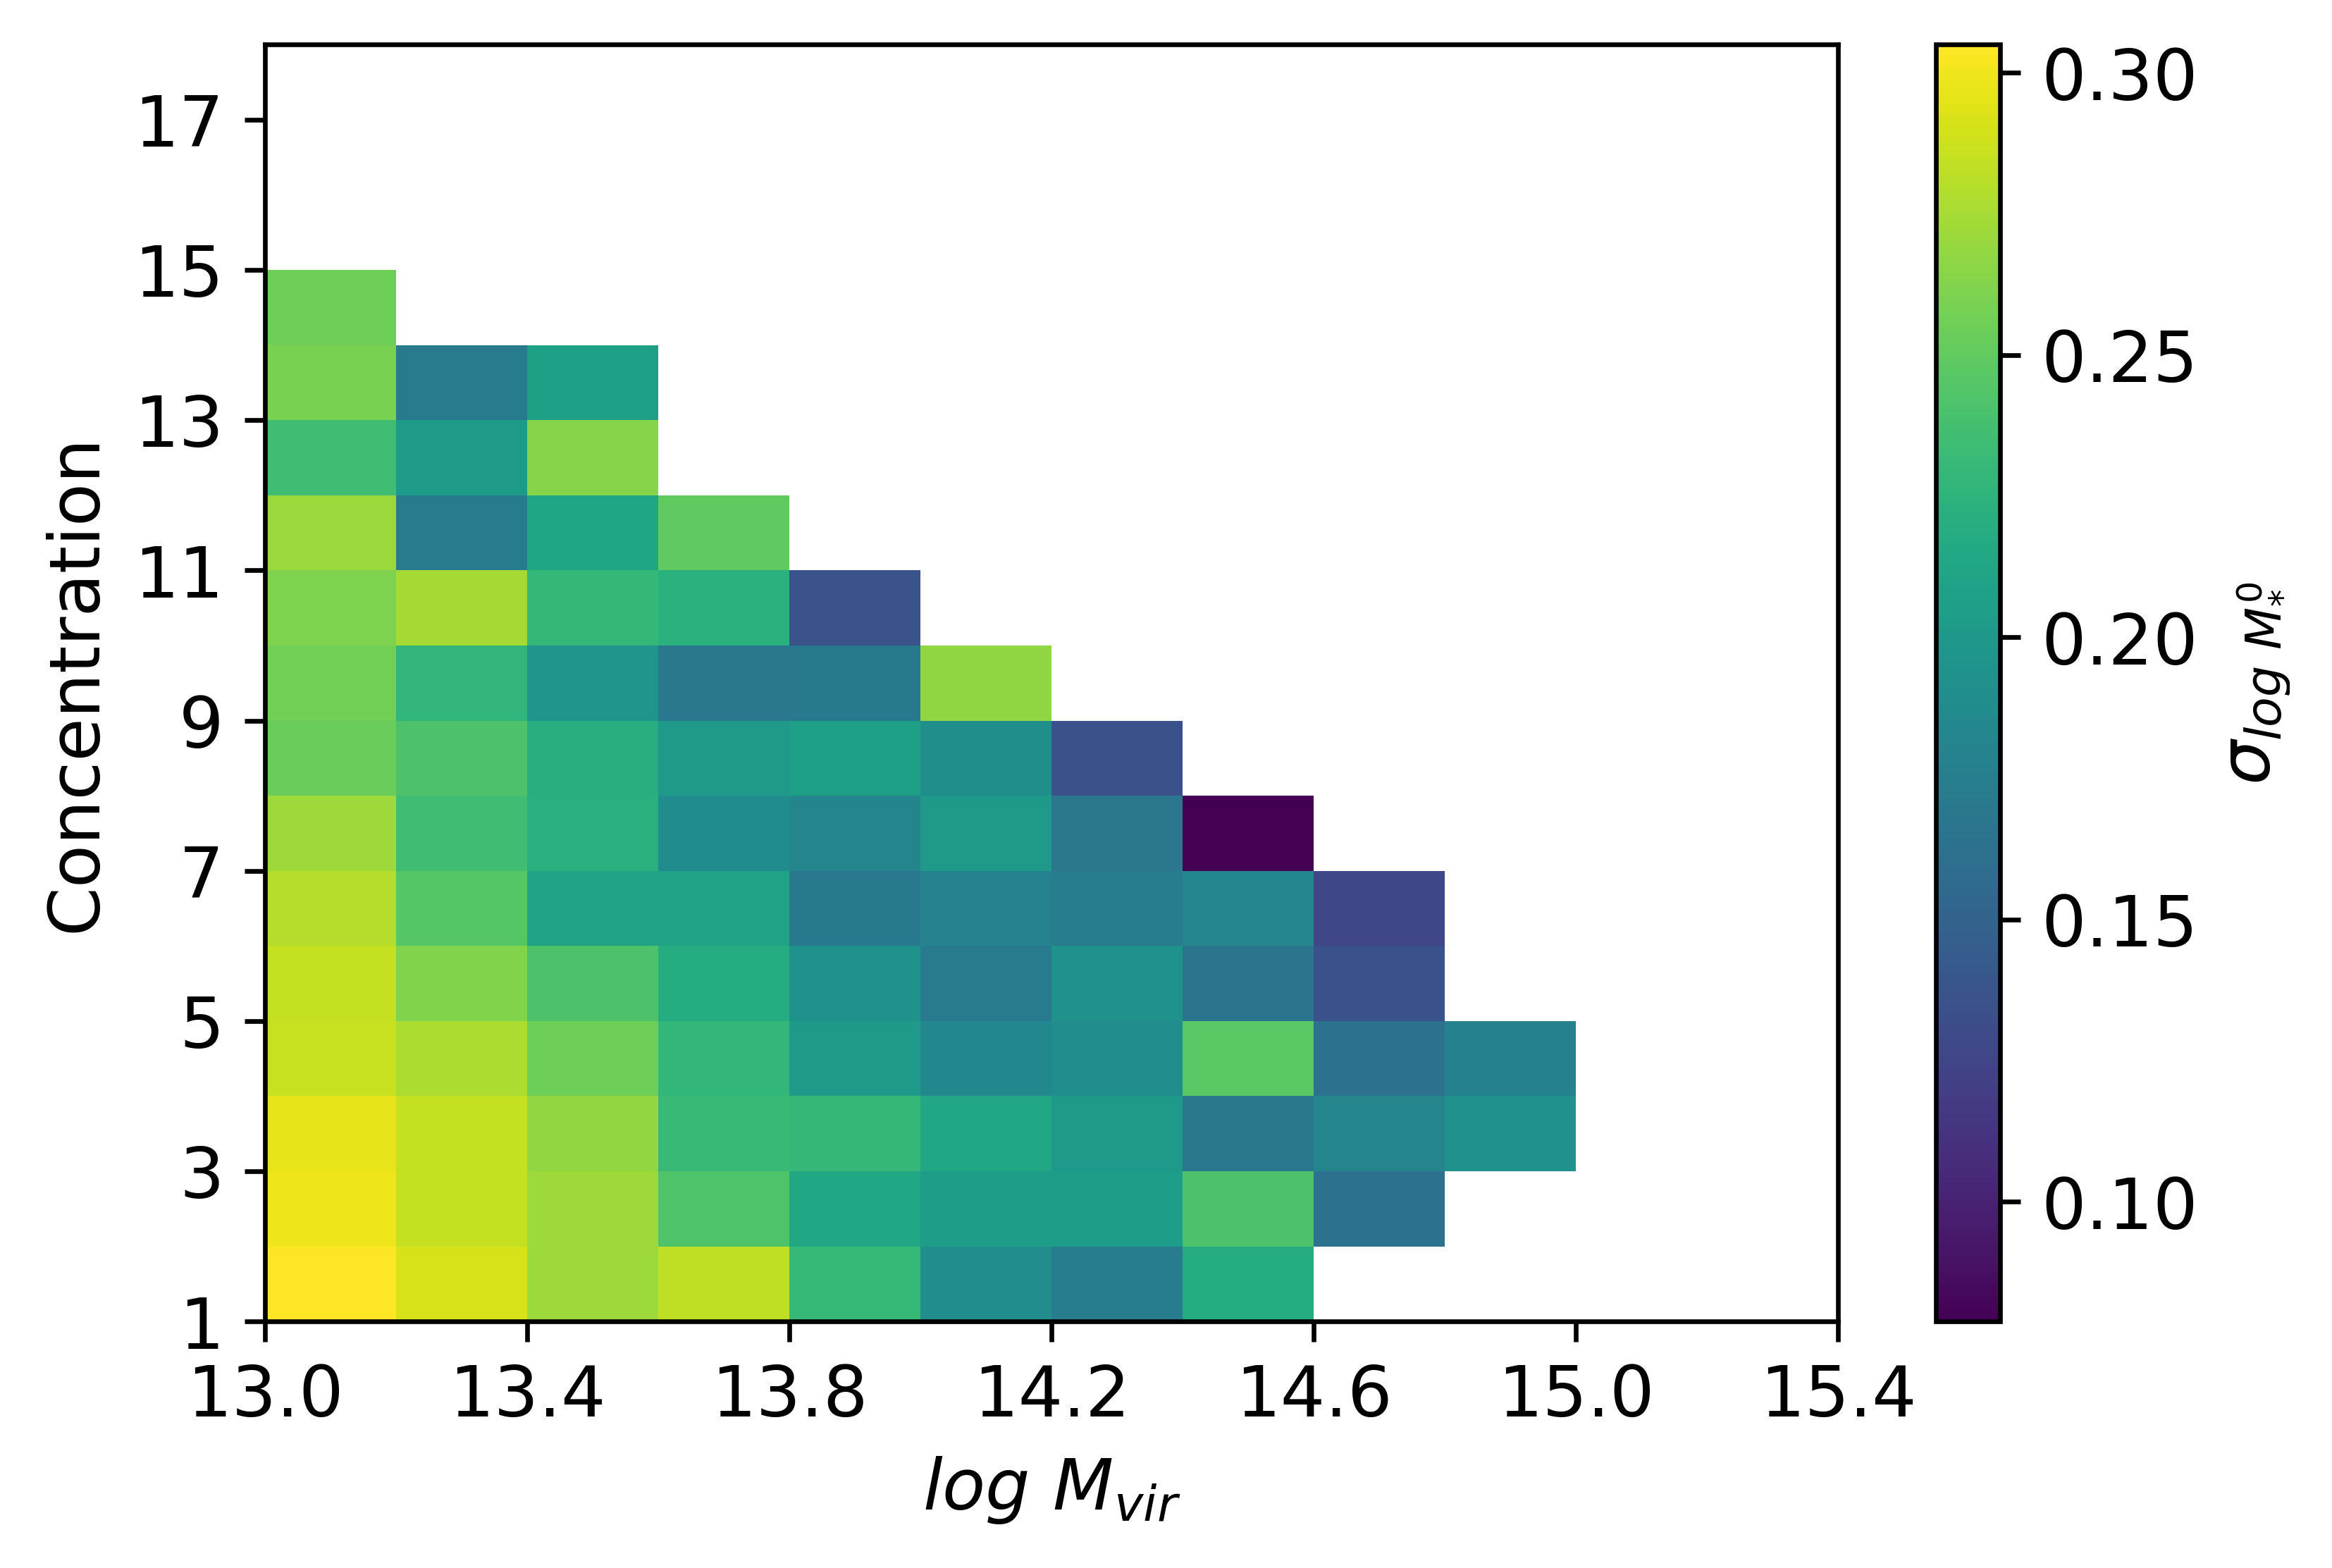

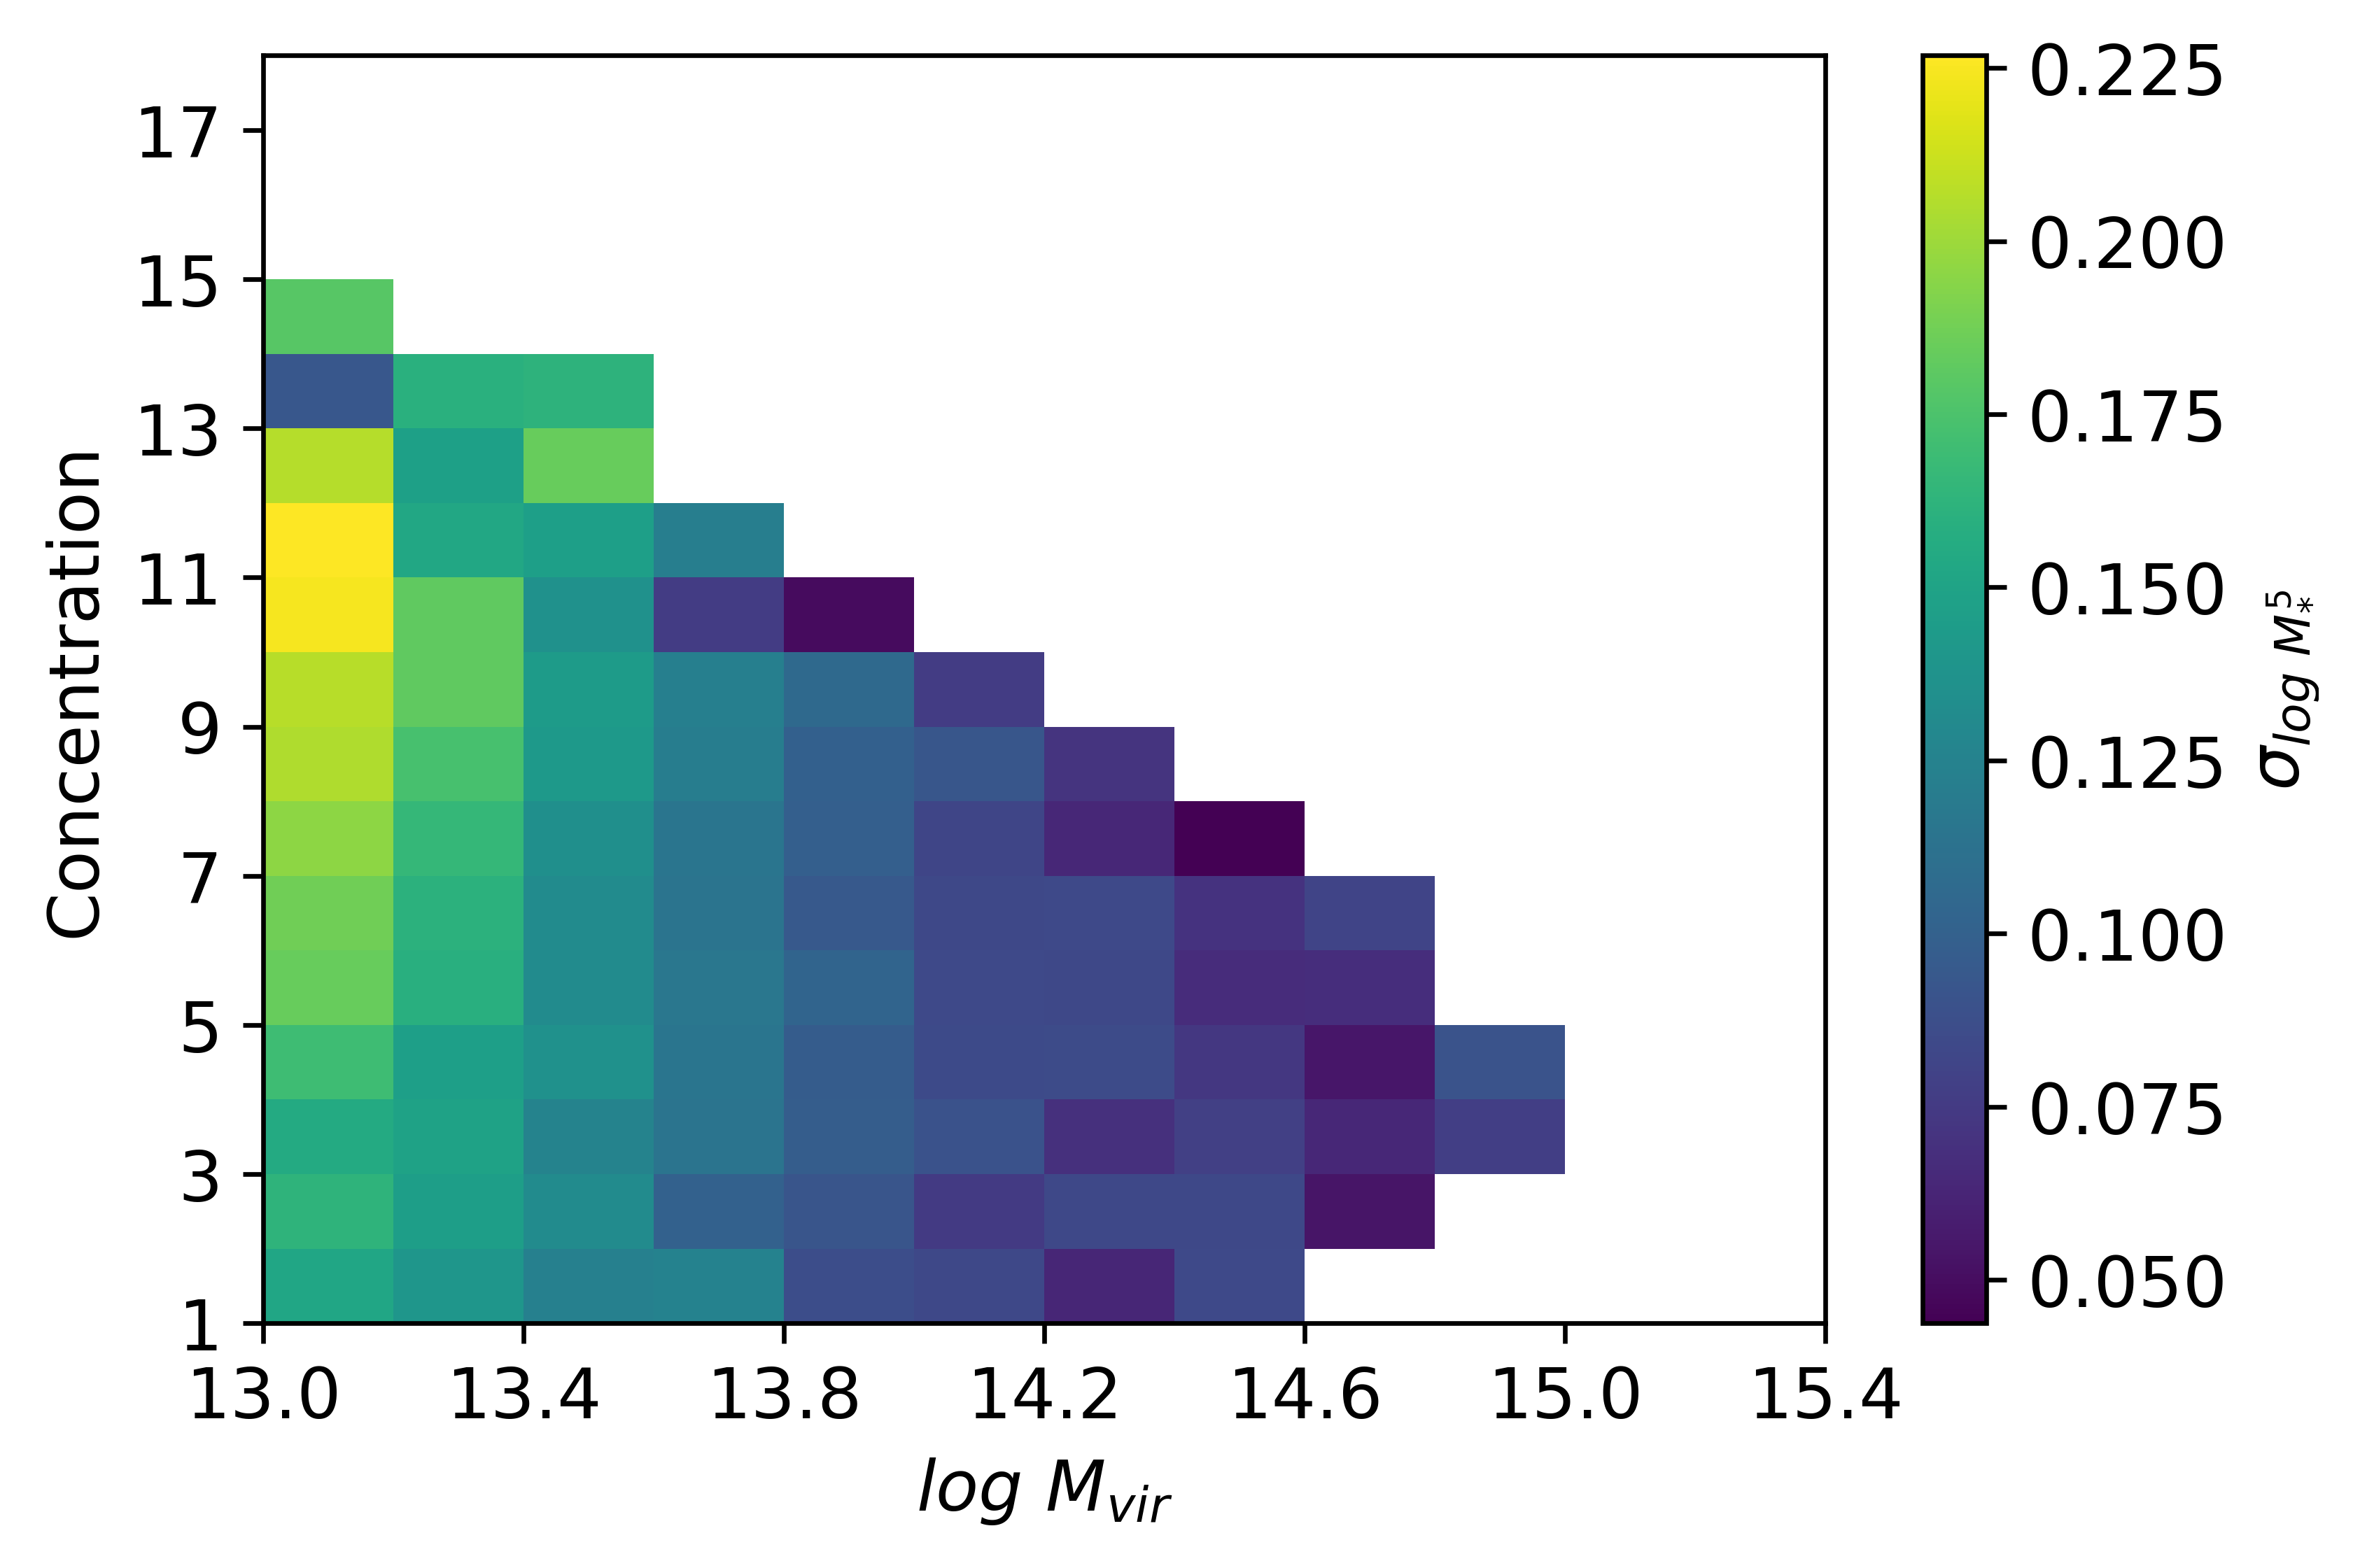

In [106]:
heatmaps.concentration_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"], 0)
heatmaps.concentration_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"], 5)

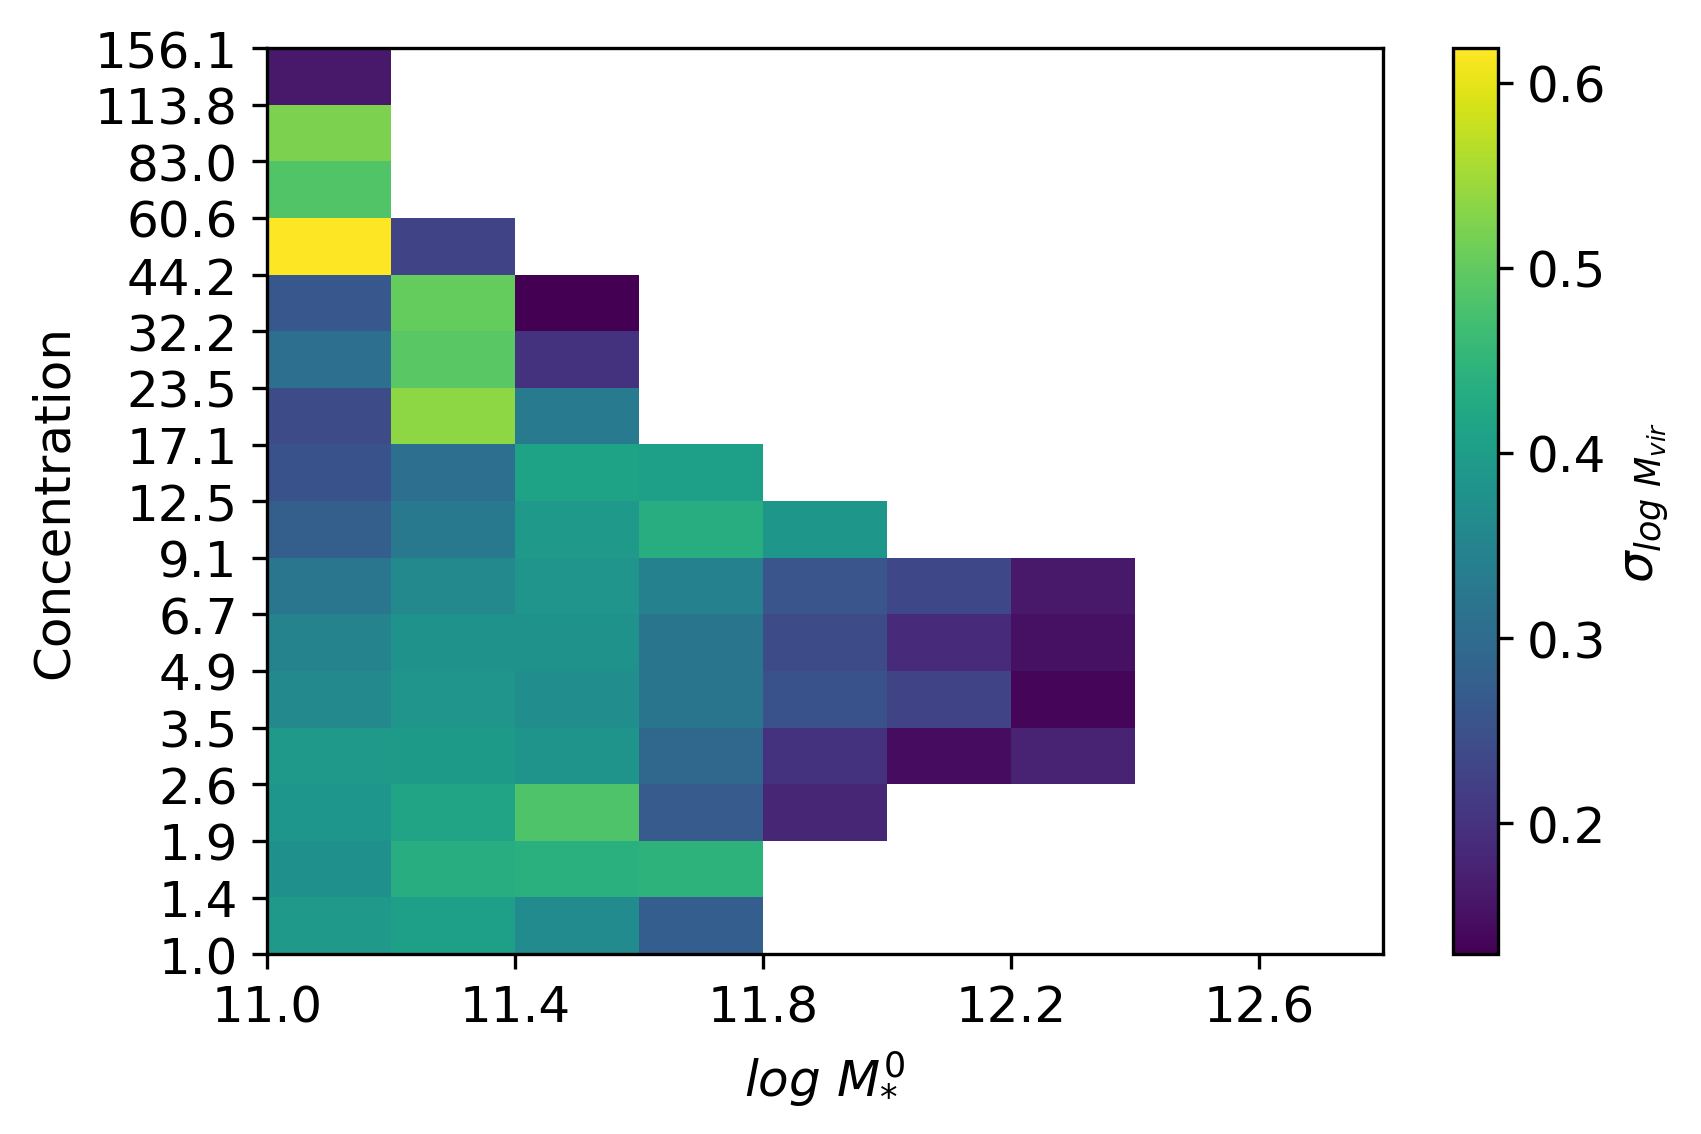

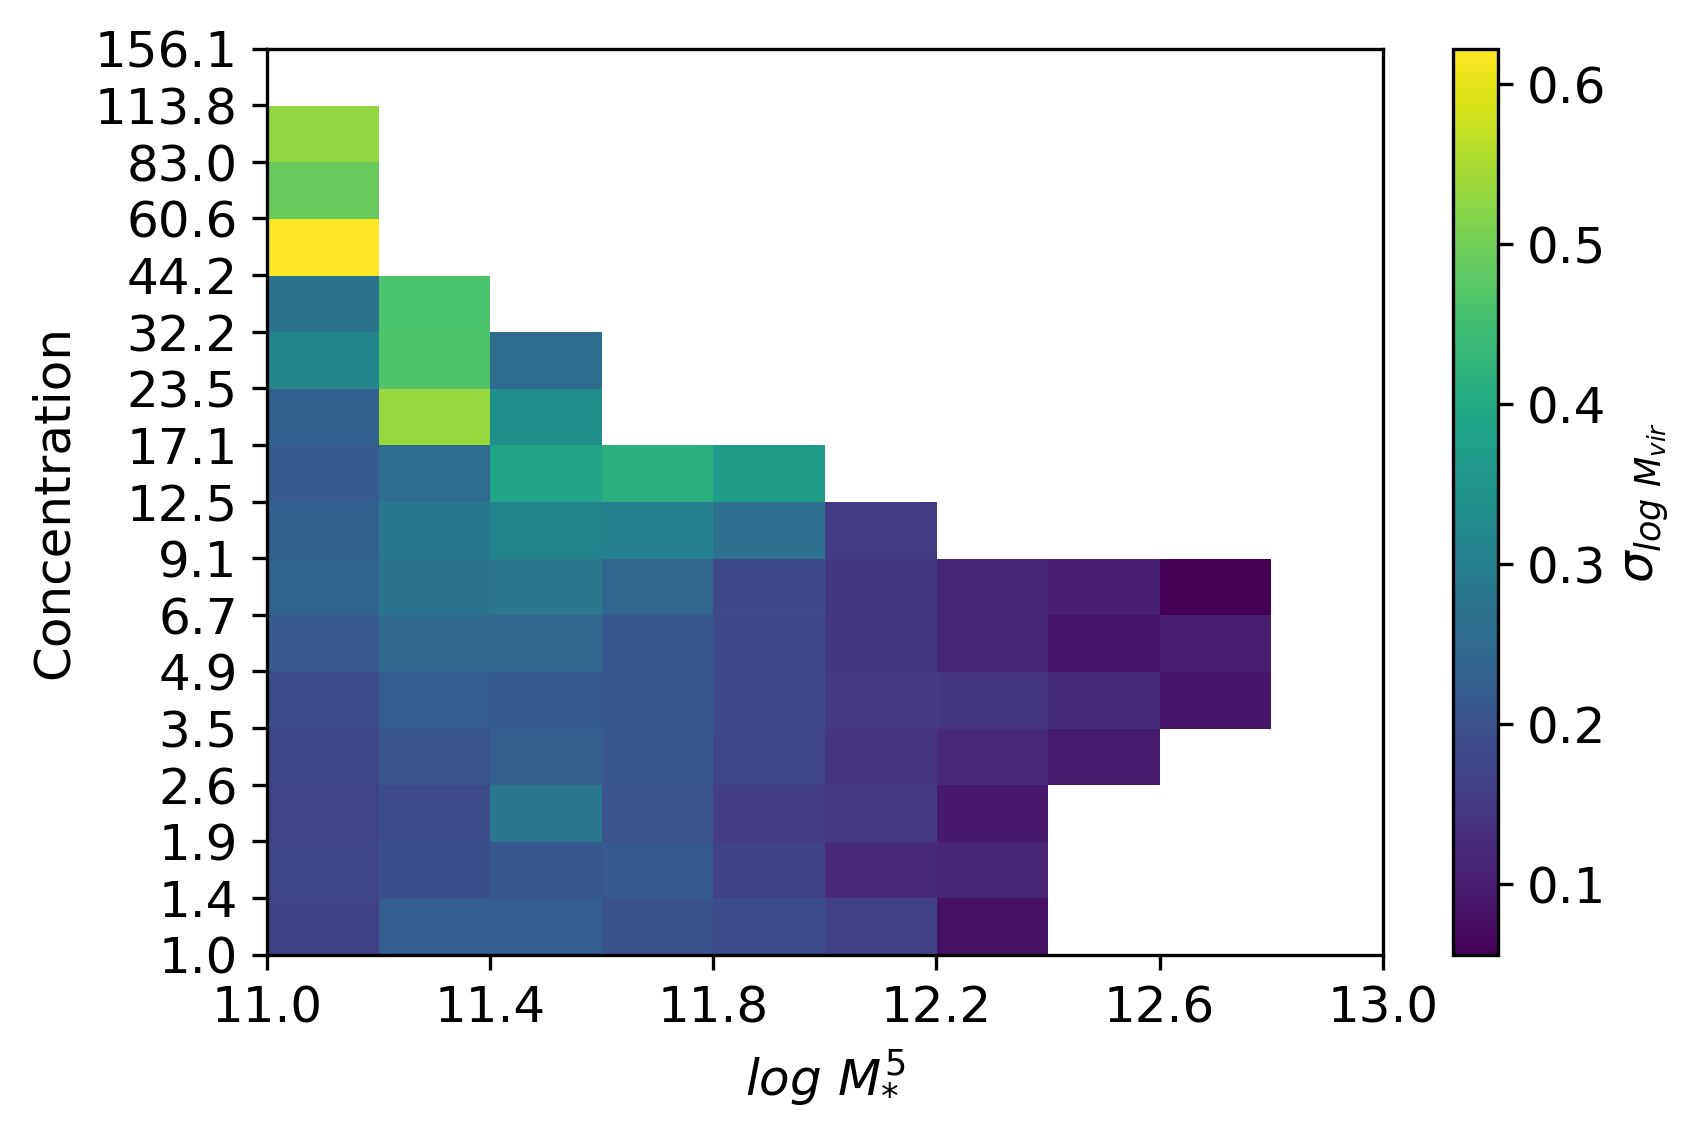

In [103]:
heatmaps.concentration_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"], 0)
heatmaps.concentration_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"], 5)

### Old

Just centrals
Total SM (including all sats)


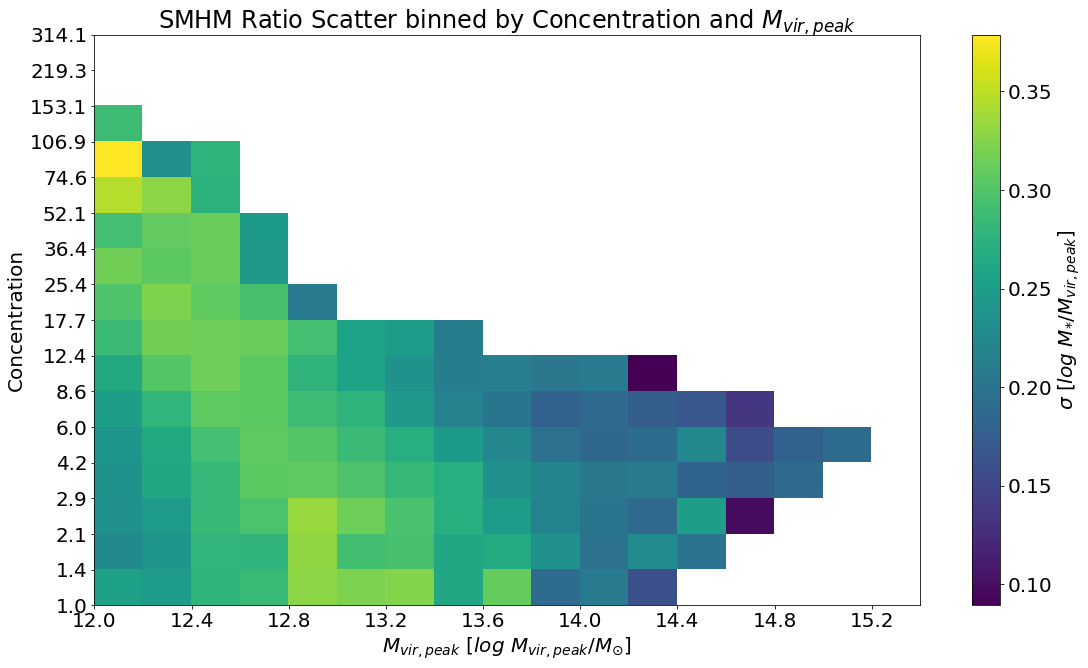

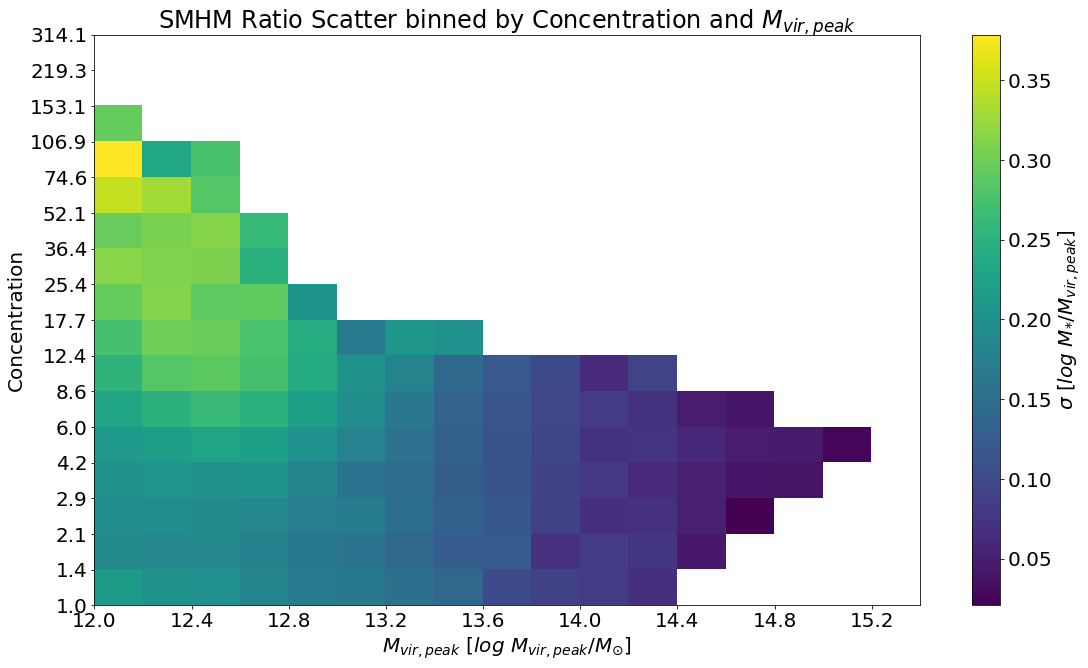

In [283]:
reload(plots)
# should probably have the centrals vs all in the title not just printed...
print("Just centrals")
plots.concentration_vs_scatter(centrals)
print("Total SM (including all sats)")
plots.concentration_vs_scatter(data["all"])

# Age

What about age?

In [548]:
print(data_halo_cut[0].dtype) # no obvious halfmass stellar scale

[('id', '<i8'), ('upid', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('m', '<f8'), ('mp', '<f8'), ('sm', '<f8'), ('icl', '<f8'), ('sfr', '<f8'), ('mvir', '<f8'), ('rvir', '<f8'), ('rs', '<f8'), ('Halfmass_Scale', '<f8'), ('scale_of_last_MM', '<f8'), ('M200b', '<f8'), ('M200c', '<f8'), ('Acc_Rate_Inst', '<f8'), ('Acc_Rate_100Myr', '<f8'), ('Acc_Rate_1*Tdyn', '<f8'), ('Acc_Rate_2*Tdyn', '<f8'), ('Acc_Rate_Mpeak', '<f8'), ('Vmax@Mpeak', '<f8')]


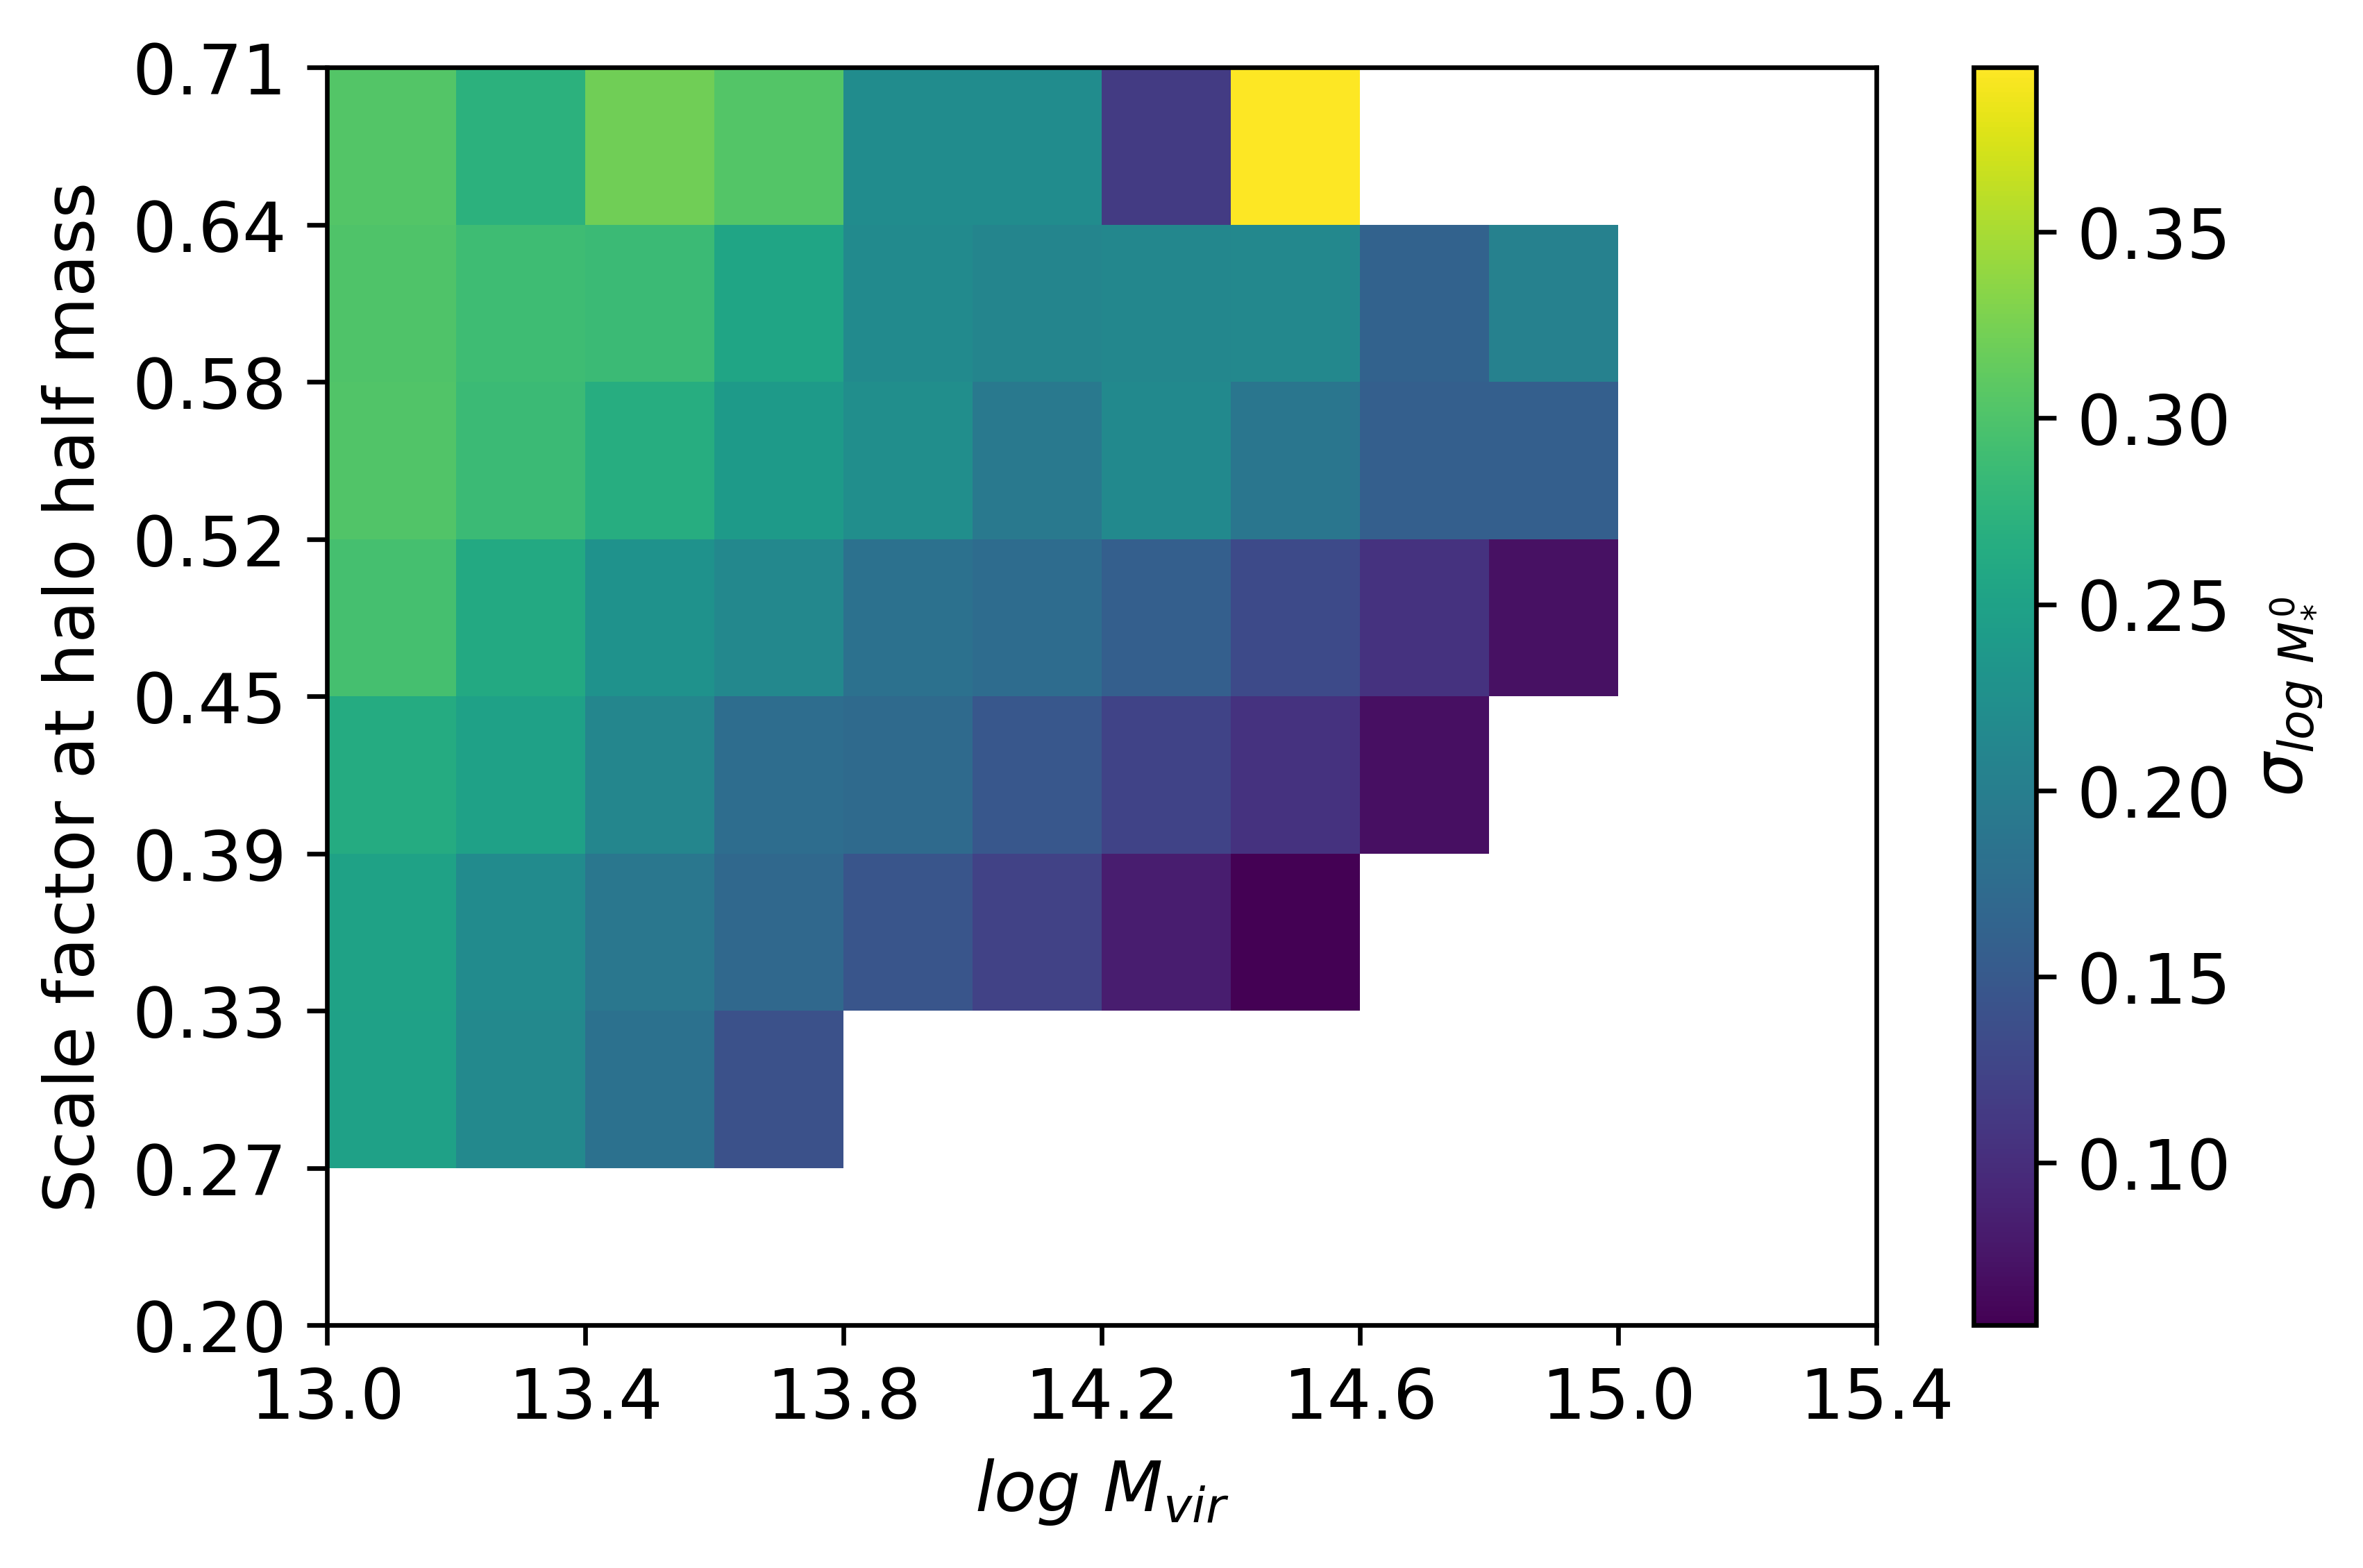

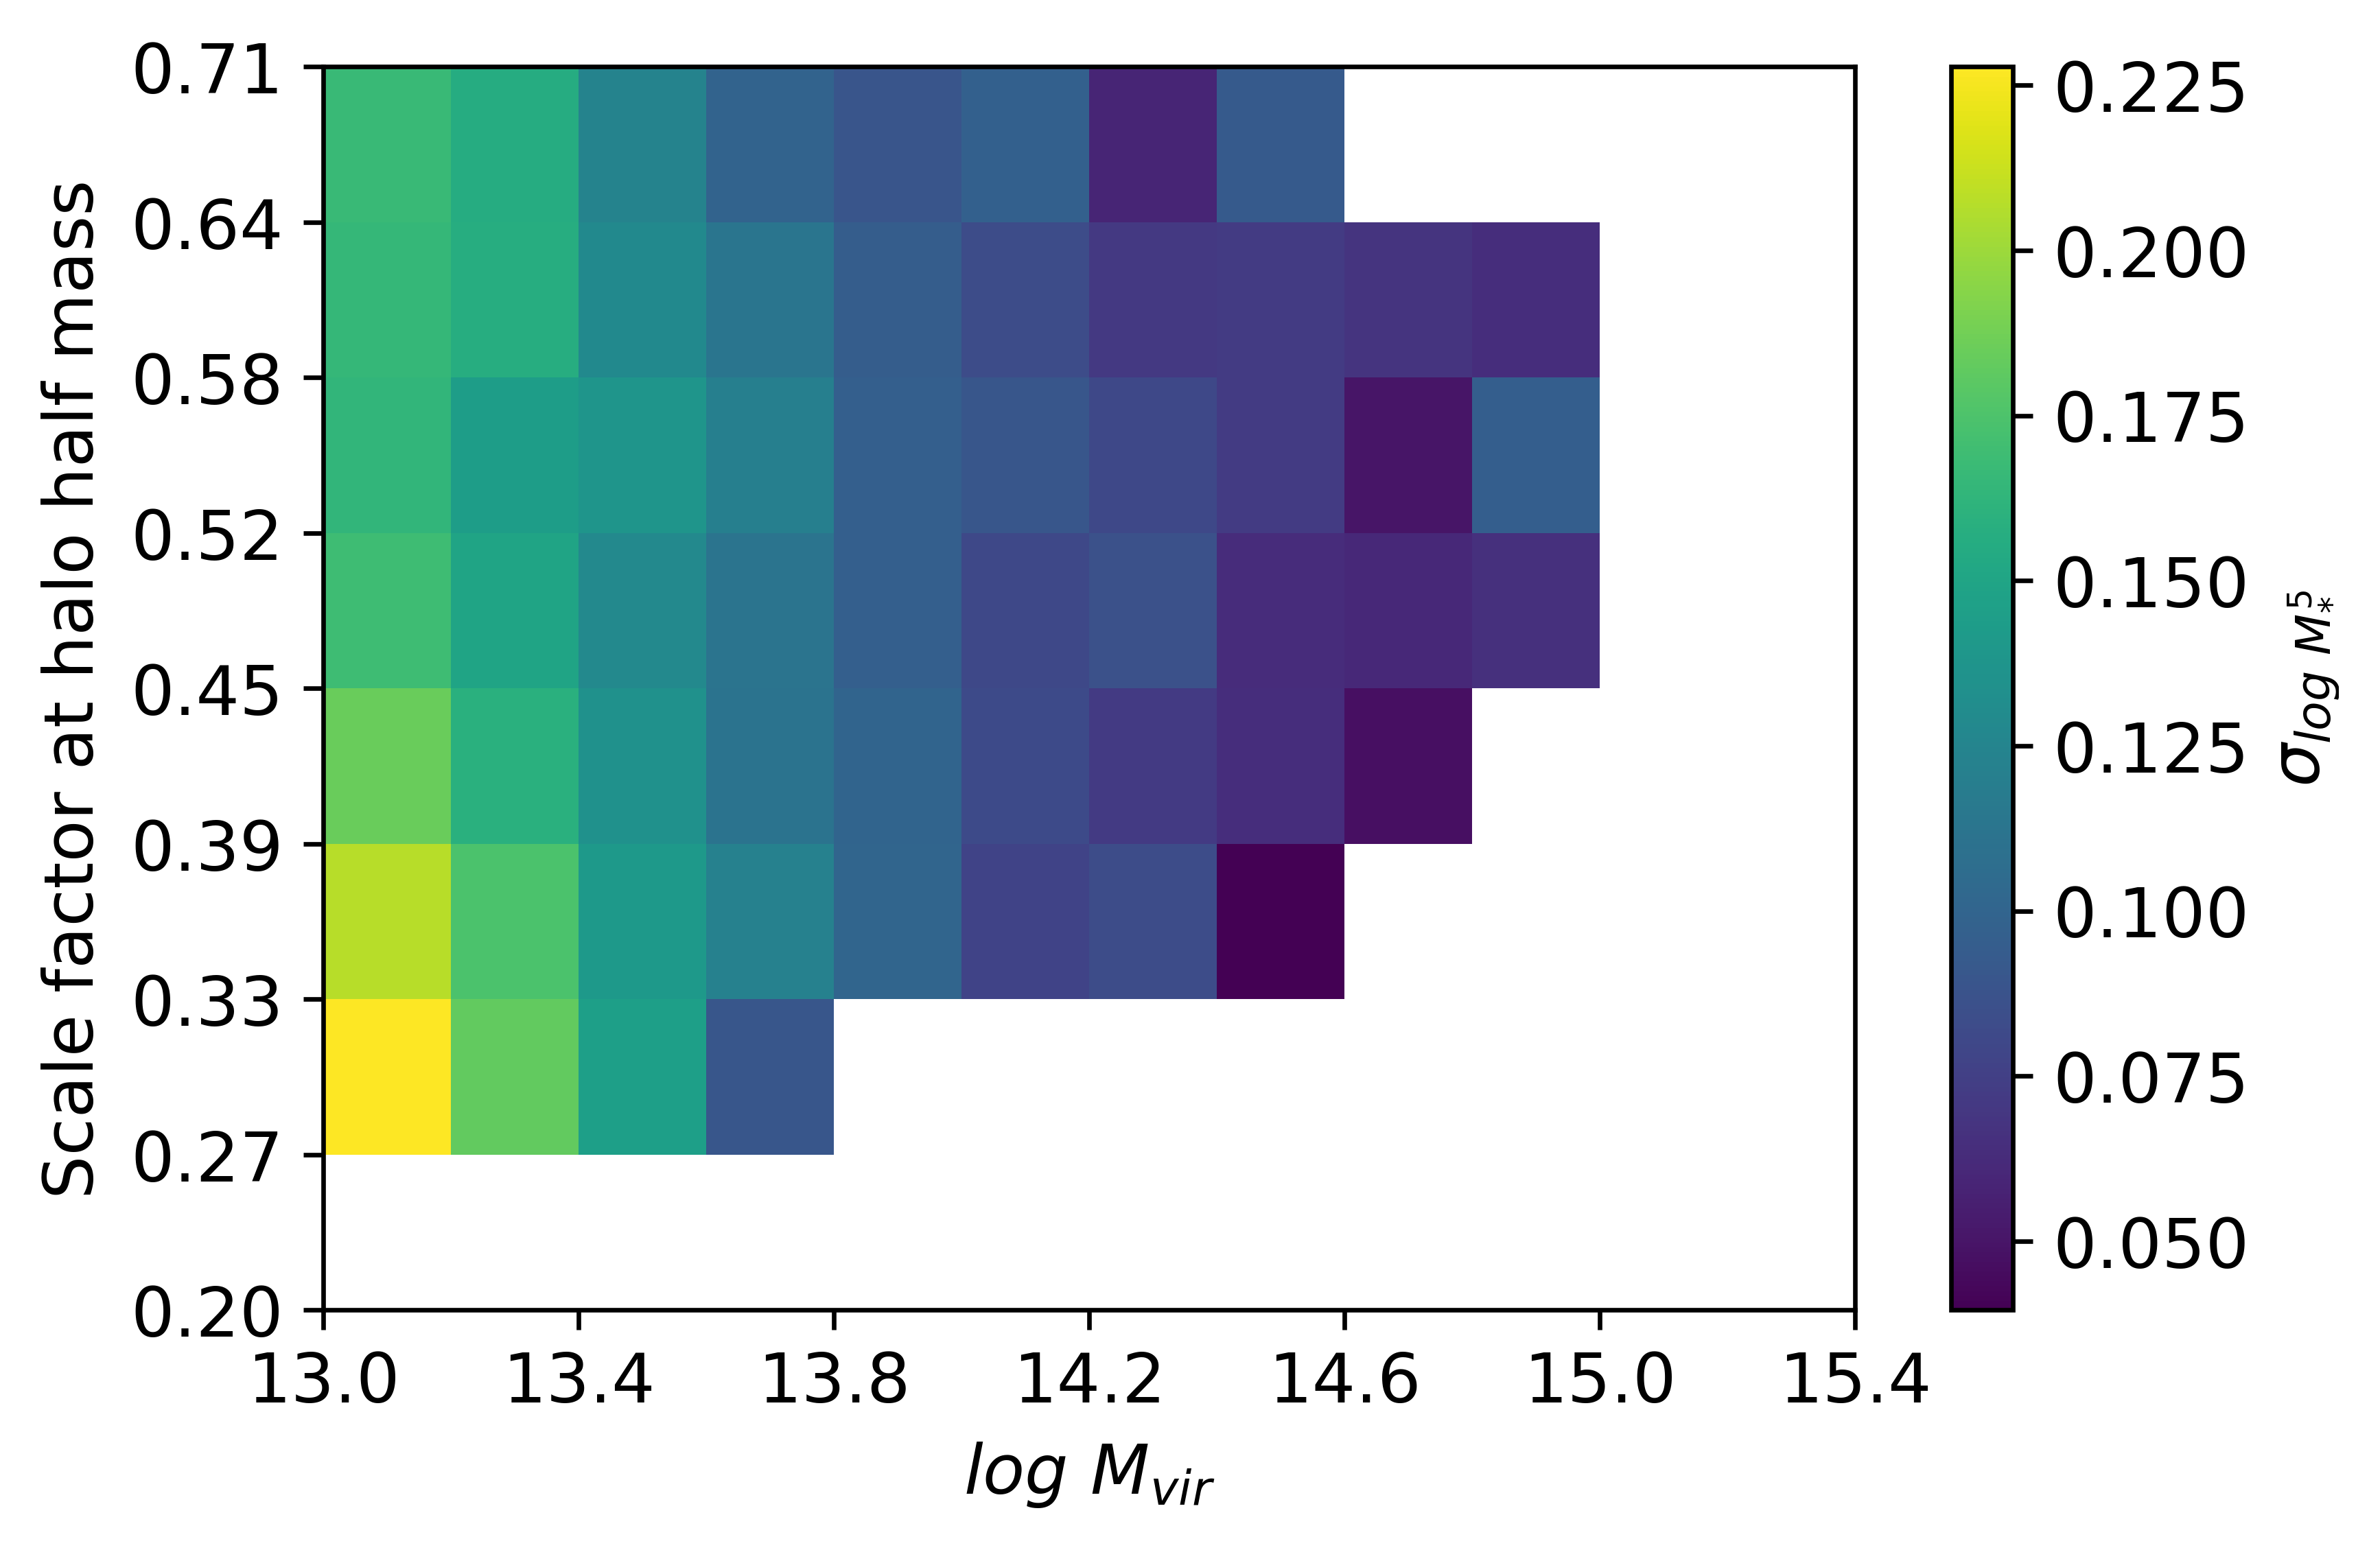

In [111]:
heatmaps.age_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"], 0)
heatmaps.age_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"], 5)

In [112]:
heatmaps.age_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"])
heatmaps.age_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"])

TypeError: age_and_sm_vs_hm_scatter() missing 1 required positional argument: 'n_sats'

# Major Mergers

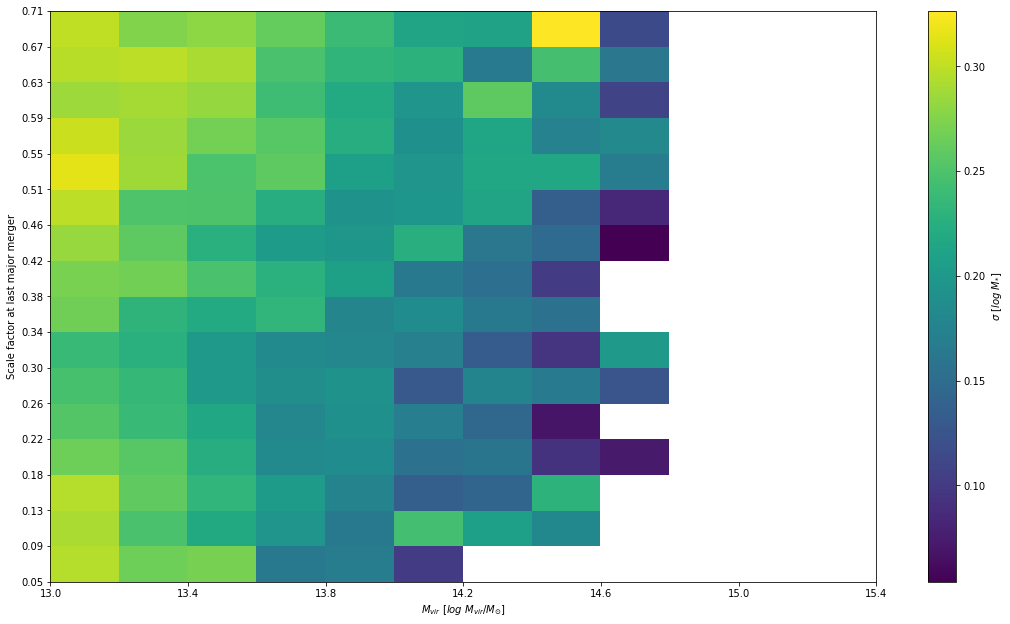

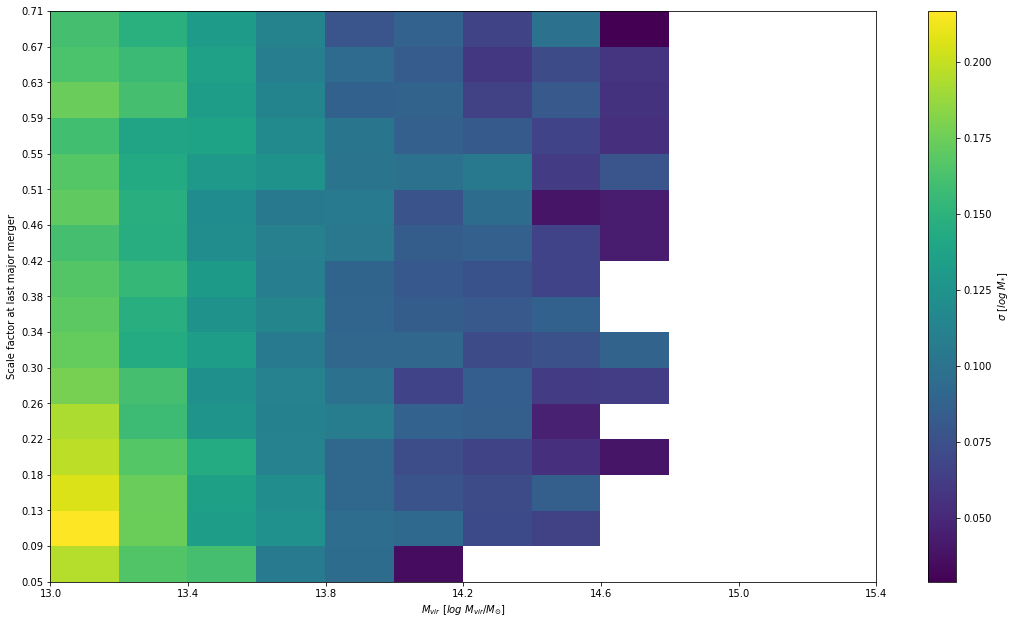

In [184]:
heatmaps.mm_and_hm_vs_sm_scatter(data_halo_cut[0]["data"], data_halo_cut[0]["fit"])
heatmaps.mm_and_hm_vs_sm_scatter(data_halo_cut[5]["data"], data_halo_cut[5]["fit"])

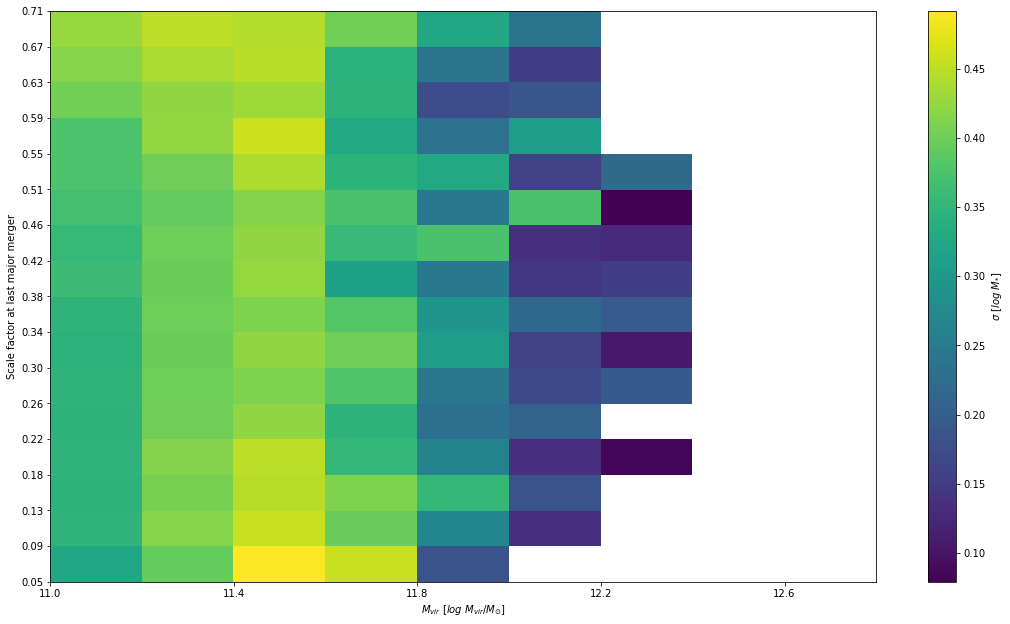

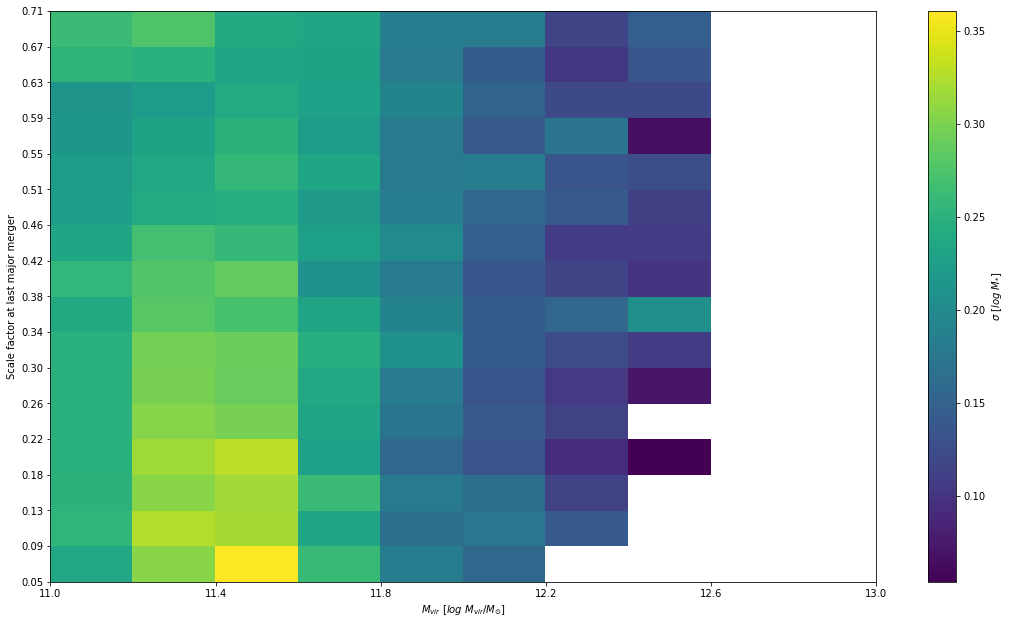

In [183]:
heatmaps.mm_and_sm_vs_hm_scatter(data_stellar_cut[0]["data"], data_stellar_cut[0]["fit"])
heatmaps.mm_and_sm_vs_hm_scatter(data_stellar_cut[5]["data"], data_stellar_cut[5]["fit"])